# Bayesian CRISPR Screen (FOXP3): Setup, Tidy Counts & QA/QC

This notebook prepares the sgRNA count data for a hierarchical Bayesian analysis, but limits scope to setup and tidy data-building stages.

- Treatment = FOXP3-low (sorted population)
- Control = FOXP3-high (sorted population)
- LFC convention (for later): log2(FOXP3-low / FOXP3-high)

Outputs produced here: a tidy long-format counts DataFrame with sample-level size factors, saved under `outputs/tables/`.

In [82]:
# Imports & options
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)

print('Libraries ready')

Libraries ready


In [83]:
# Paths
project_root = Path('..').resolve().parent  # adjust if needed
data_dir = project_root / 'data'
fig_dir = project_root / 'outputs' / 'figures'
table_dir = project_root / 'outputs' / 'tables'

sgrna_file = data_dir / 'sgrna_summary.csv'

# Ensure outputs exist
fig_dir.mkdir(parents=True, exist_ok=True)
table_dir.mkdir(parents=True, exist_ok=True)

print('Data dir  :', data_dir)
print('Figures   :', fig_dir)
print('Tables    :', table_dir)
print('sgRNA file:', sgrna_file)

Data dir  : /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/data
Figures   : /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures
Tables    : /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables
sgRNA file: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/data/sgrna_summary.csv


In [84]:
# Load sgRNA summary (wide format)
assert sgrna_file.exists(), f'Missing file: {sgrna_file}'
sgrna_wide = pd.read_csv(sgrna_file)
print(f'Loaded sgRNA rows: {len(sgrna_wide):,}')

# Peek
display(sgrna_wide.head())

# Required columns sanity check
required_cols = {'sgrna','Gene','control_count','treatment_count'}
missing = required_cols - set(sgrna_wide.columns)
assert not missing, f'Missing required columns: {missing}'

Loaded sgRNA rows: 77,487


,sgrna,Gene,control_count,treatment_count,control_mean,treat_mean,LFC,control_var,adj_var,score,p.low,p.high,p.twosided,FDR,high_in_treatment
0,77449,FOXP3,181.16/186.77,10106/5287.9,183.96,7696.9,5.3792,15.7130,1576.90,189.19,1.0,0.0,0.0,0.0,True
1,17754,SMARCB1,81.278/78.442,4371/4091.6,79.86,4231.3,5.7099,4.0202,642.01,163.85,1.0,0.0,0.0,0.0,True
2,37463,FOXP3,102.82/143.81,7527.5/2948.8,123.32,5238.1,5.3972,840.0700,1025.00,159.76,1.0,0.0,0.0,0.0,True
3,77453,FOXP3,290.84/84.045,8696.1/3933.5,187.44,6314.8,5.0668,21381.0000,1609.10,152.75,1.0,0.0,0.0,0.0,True
4,77477,FOXP3,54.348/22.412,3420.9/1395.3,38.38,2408.1,5.9349,509.9600,291.78,138.73,1.0,0.0,0.0,0.0,True


In [85]:
# Helper to parse 'a/b' replicate fields into two floats

def _parse_two_reps(val):
    # Returns (rep1, rep2) as floats (np.nan if unavailable)
    if pd.isna(val):
        return np.nan, np.nan
    # Try string normalization
    try:
        s = str(val).strip()
    except Exception:
        return np.nan, np.nan
    parts = [p.strip() for p in s.split('/') if p.strip() != '']

    if len(parts) == 0:
        return np.nan, np.nan
    if len(parts) == 1:
        try:
            x = float(parts[0])
        except Exception:
            x = np.nan
        return x, x

    # len(parts) >= 2 → take first two entries
    try:
        a = float(parts[0])
    except Exception:
        a = np.nan
    try:
        b = float(parts[1])
    except Exception:
        b = np.nan
    return a, b

print("Helper _parse_two_reps ready")

Helper _parse_two_reps ready


In [86]:
# Parse replicate counts and attach numeric columns
ctrl_r1, ctrl_r2 = zip(*sgrna_wide['control_count'].map(_parse_two_reps))
trt_r1, trt_r2   = zip(*sgrna_wide['treatment_count'].map(_parse_two_reps))

sgrna_wide = sgrna_wide.assign(
    control_r1=pd.to_numeric(ctrl_r1, errors='coerce'),
    control_r2=pd.to_numeric(ctrl_r2, errors='coerce'),
    treatment_r1=pd.to_numeric(trt_r1, errors='coerce'),
    treatment_r2=pd.to_numeric(trt_r2, errors='coerce')
)

display(sgrna_wide[['sgrna','Gene','control_r1','control_r2','treatment_r1','treatment_r2']].head())

,sgrna,Gene,control_r1,control_r2,treatment_r1,treatment_r2
0,77449,FOXP3,181.160,186.770,10106.0,5287.9
1,17754,SMARCB1,81.278,78.442,4371.0,4091.6
2,37463,FOXP3,102.820,143.810,7527.5,2948.8
3,77453,FOXP3,290.840,84.045,8696.1,3933.5
4,77477,FOXP3,54.348,22.412,3420.9,1395.3


In [92]:
# Build tidy long-form count table (one row per sgRNA x sample)
# Assumptions:
# - treatment = FOXP3-low; control = FOXP3-high
# - Two replicates for each condition: r1, r2

rows = []
for _, row in sgrna_wide.iterrows():
    sg = row['sgrna']
    gene = row['Gene']
    # Control (FOXP3-high)
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'control',
        'replicate': 1,
        'sample_id': 'control_r1',
        'count': row.get('control_r1', np.nan)
    })
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'control',
        'replicate': 2,
        'sample_id': 'control_r2',
        'count': row.get('control_r2', np.nan)
    })
    # Treatment (FOXP3-low)
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'treatment',
        'replicate': 1,
        'sample_id': 'treatment_r1',
        'count': row.get('treatment_r1', np.nan)
    })
    rows.append({
        'sgrna': sg,
        'gene': gene,
        'condition': 'treatment',
        'replicate': 2,
        'sample_id': 'treatment_r2',
        'count': row.get('treatment_r2', np.nan)
    })

counts_long = pd.DataFrame(rows)

# Library-size normalization: per-sample size factors
lib_sizes = counts_long.groupby('sample_id')['count'].sum()
geom_mean = np.exp(np.log(lib_sizes.replace(0, np.nan)).mean())
size_factors = (lib_sizes / geom_mean).replace([np.inf, -np.inf], np.nan)
size_factors = size_factors.fillna(1.0)
size_factors = size_factors.rename('size_factor').reset_index()

# Add size factors (counts_long already has condition/replicate)
counts_long = counts_long.merge(size_factors, on='sample_id', how='left')

print('Tidy counts shape:', counts_long.shape)
print('Samples:', counts_long['sample_id'].unique())
print('NaN counts:', counts_long['count'].isna().sum())

display(counts_long.head())

Tidy counts shape: (309948, 7)
Samples: ['control_r1' 'control_r2' 'treatment_r1' 'treatment_r2']
NaN counts: 0


,sgrna,gene,condition,replicate,sample_id,count,size_factor
0,77449,FOXP3,control,1,control_r1,181.160,0.993118
1,77449,FOXP3,control,2,control_r2,186.770,0.999318
2,77449,FOXP3,treatment,1,treatment_r1,10106.000,1.002837
3,77449,FOXP3,treatment,2,treatment_r2,5287.900,1.004766
4,17754,SMARCB1,control,1,control_r1,81.278,0.993118


In [93]:
# QA/QC: Sample-level summaries
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

plt.style.use('arviz-docgrid')

# Totals, zeros, unique sgRNAs per sample
sample_totals = counts_long.groupby('sample_id')['count'].sum().rename('total_count')
zero_counts = (
    counts_long.assign(is_zero=(counts_long['count'] == 0))
    .groupby('sample_id')['is_zero']
    .sum()
    .rename('zero_count')
)
n_sgrna = counts_long.groupby('sample_id')['sgrna'].nunique().rename('n_sgrna')

# Size factors (already merged)
sf = (
    counts_long[['sample_id','size_factor']]
    .drop_duplicates()
    .set_index('sample_id')['size_factor']
)

summary = pd.concat([sample_totals, zero_counts, n_sgrna, sf], axis=1).reset_index()
summary['nonzero'] = summary['n_sgrna'] - summary['zero_count']

print('QA/QC — sample summary:')
display(summary)


QA/QC — sample summary:


,sample_id,total_count,zero_count,n_sgrna,size_factor,nonzero
0,control_r1,2.716991e+07,8,77487,0.993118,77479
1,control_r2,2.733954e+07,14,77487,0.999318,77473
2,treatment_r1,2.743582e+07,2,77487,1.002837,77485
3,treatment_r2,2.748858e+07,7,77487,1.004766,77480


In [94]:
# Save tidy counts to outputs/tables
out_path = table_dir / 'tidy_counts.csv'
counts_long.to_csv(out_path, index=False)
print(f'Saved tidy counts to: {out_path}')

Saved tidy counts to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/tidy_counts.csv


Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/qc_sizefactors_total_counts.png


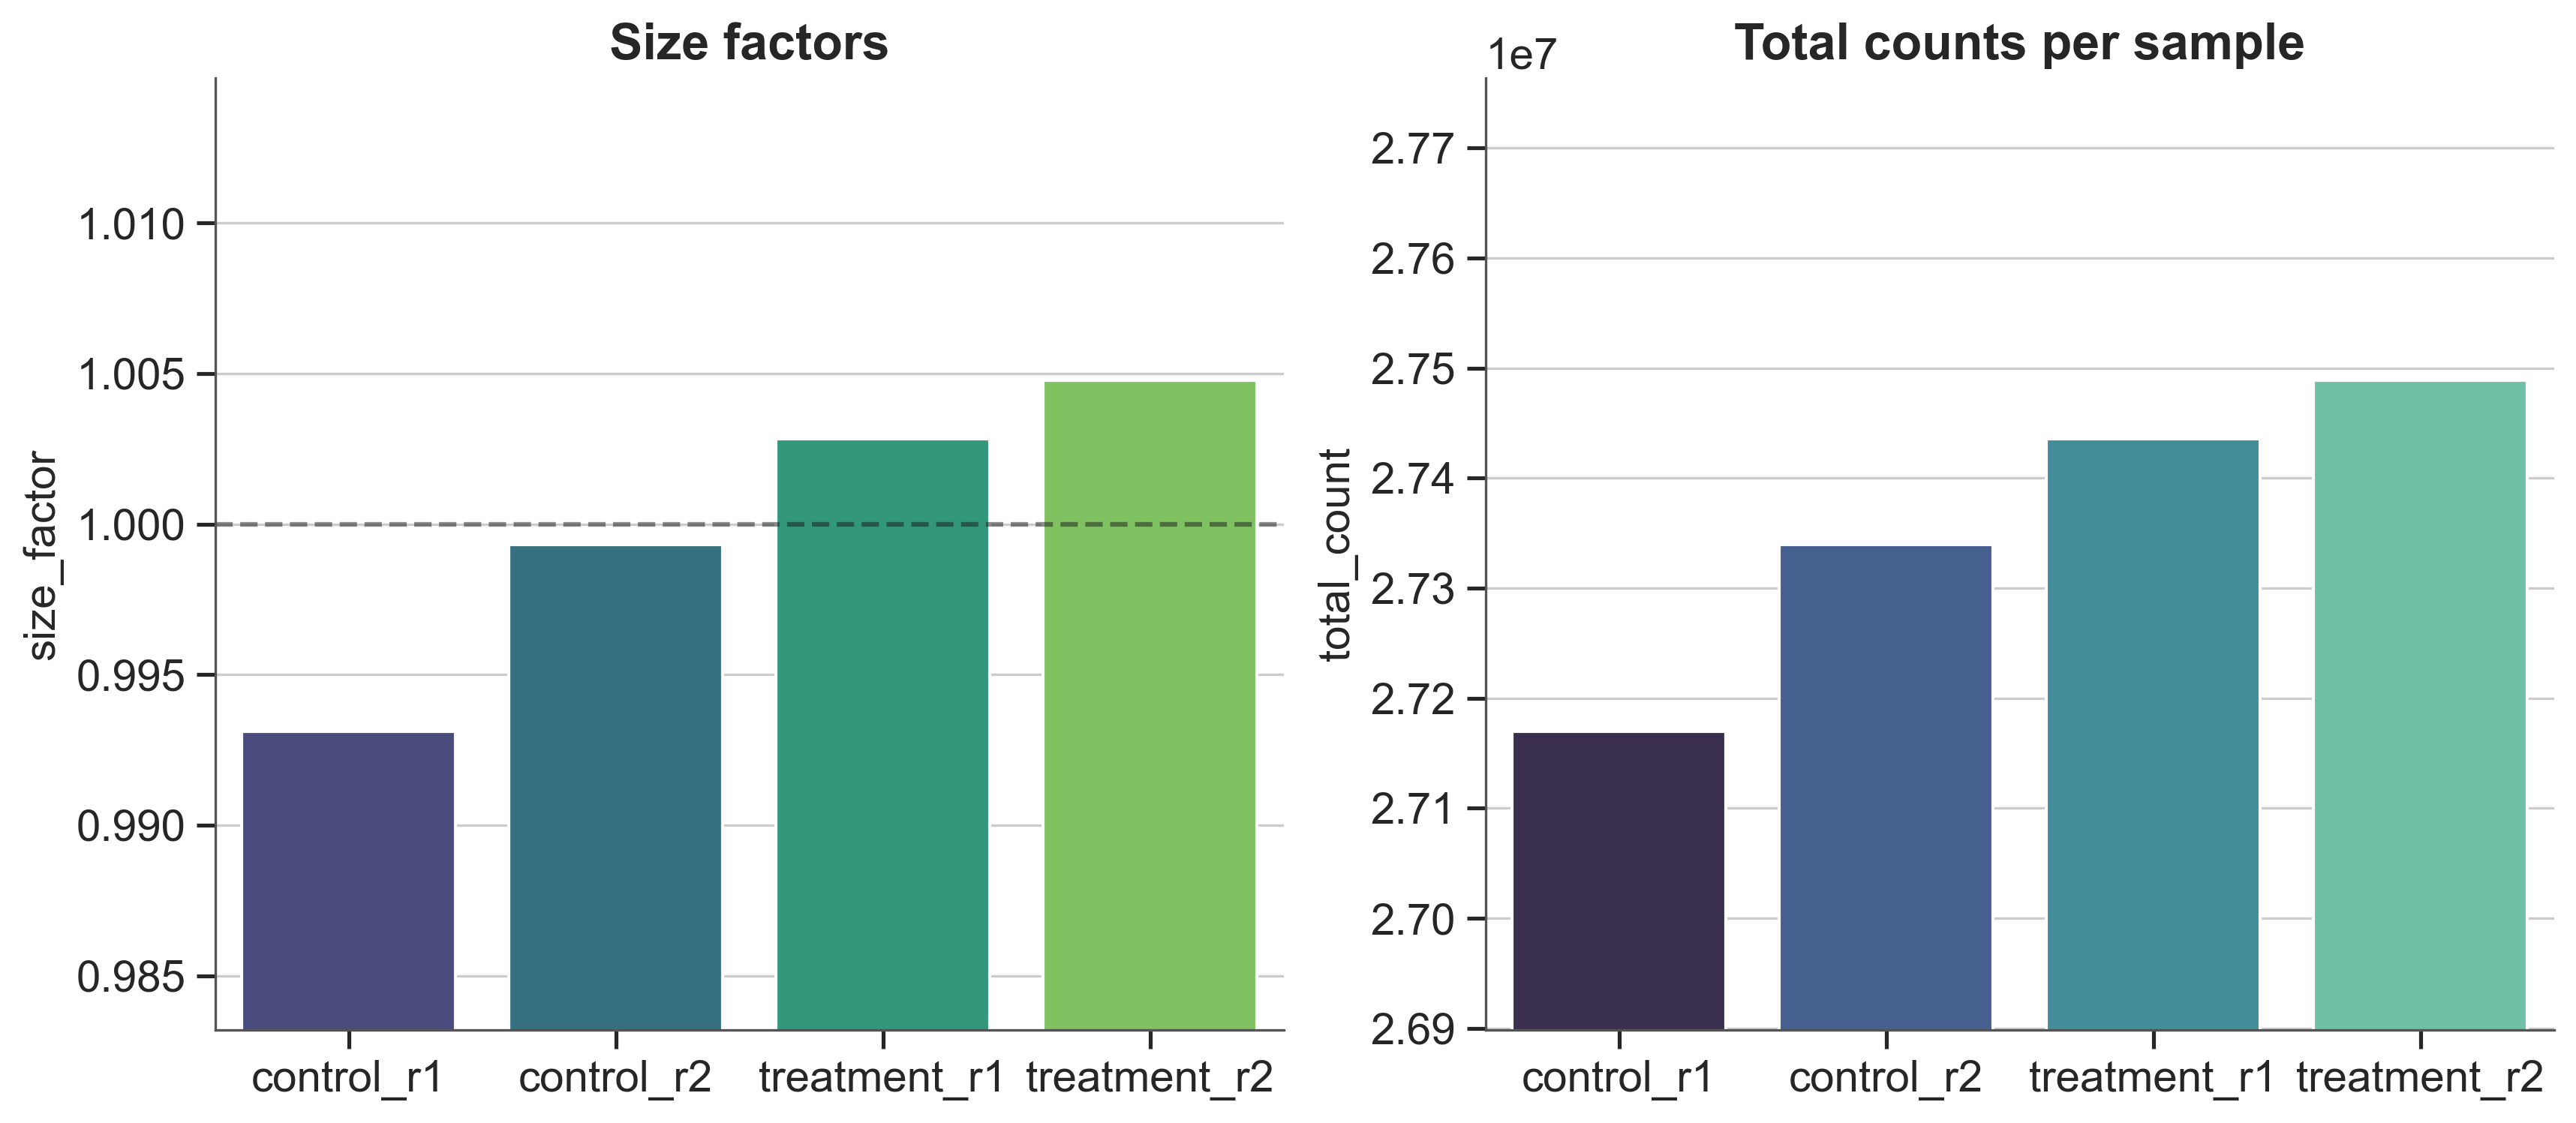

In [95]:
# QA/QC: Size factor bar plot and total counts
fig, axes = plt.subplots(1, 2)

sns.barplot(ax=axes[0], x='sample_id', y='size_factor', data=summary, palette='viridis')
axes[0].set_title('Size factors')
axes[0].set_xlabel('')
axes[0].axhline(1.0, color='k', linestyle='--', alpha=0.5)
axes[0].set_ylim(summary['size_factor'].min() * .99, summary['size_factor'].max() * 1.01)

sns.barplot(ax=axes[1], x='sample_id', y='total_count', data=summary, palette='mako')
axes[1].set_title('Total counts per sample')
axes[1].set_xlabel('')
axes[1].set_ylim(summary['total_count'].min() * 0.99, summary['total_count'].max() * 1.01)

# Improve x-label readability: smaller font size and slight rotation
#for ax in axes:
#    plt.setp(ax.get_xticklabels(), rotation=25, ha='right', fontsize=8)
#    ax.tick_params(axis='x', which='major', pad=6)

plt.tight_layout()
# Save figure
fig_dir.mkdir(parents=True, exist_ok=True)
out_path_fig = fig_dir / 'qc_sizefactors_total_counts.png'
fig.savefig(str(out_path_fig), dpi=150, bbox_inches='tight')
print(f'Saved figure: {out_path_fig}')
plt.show()

Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/qc_replicate_concordance.png


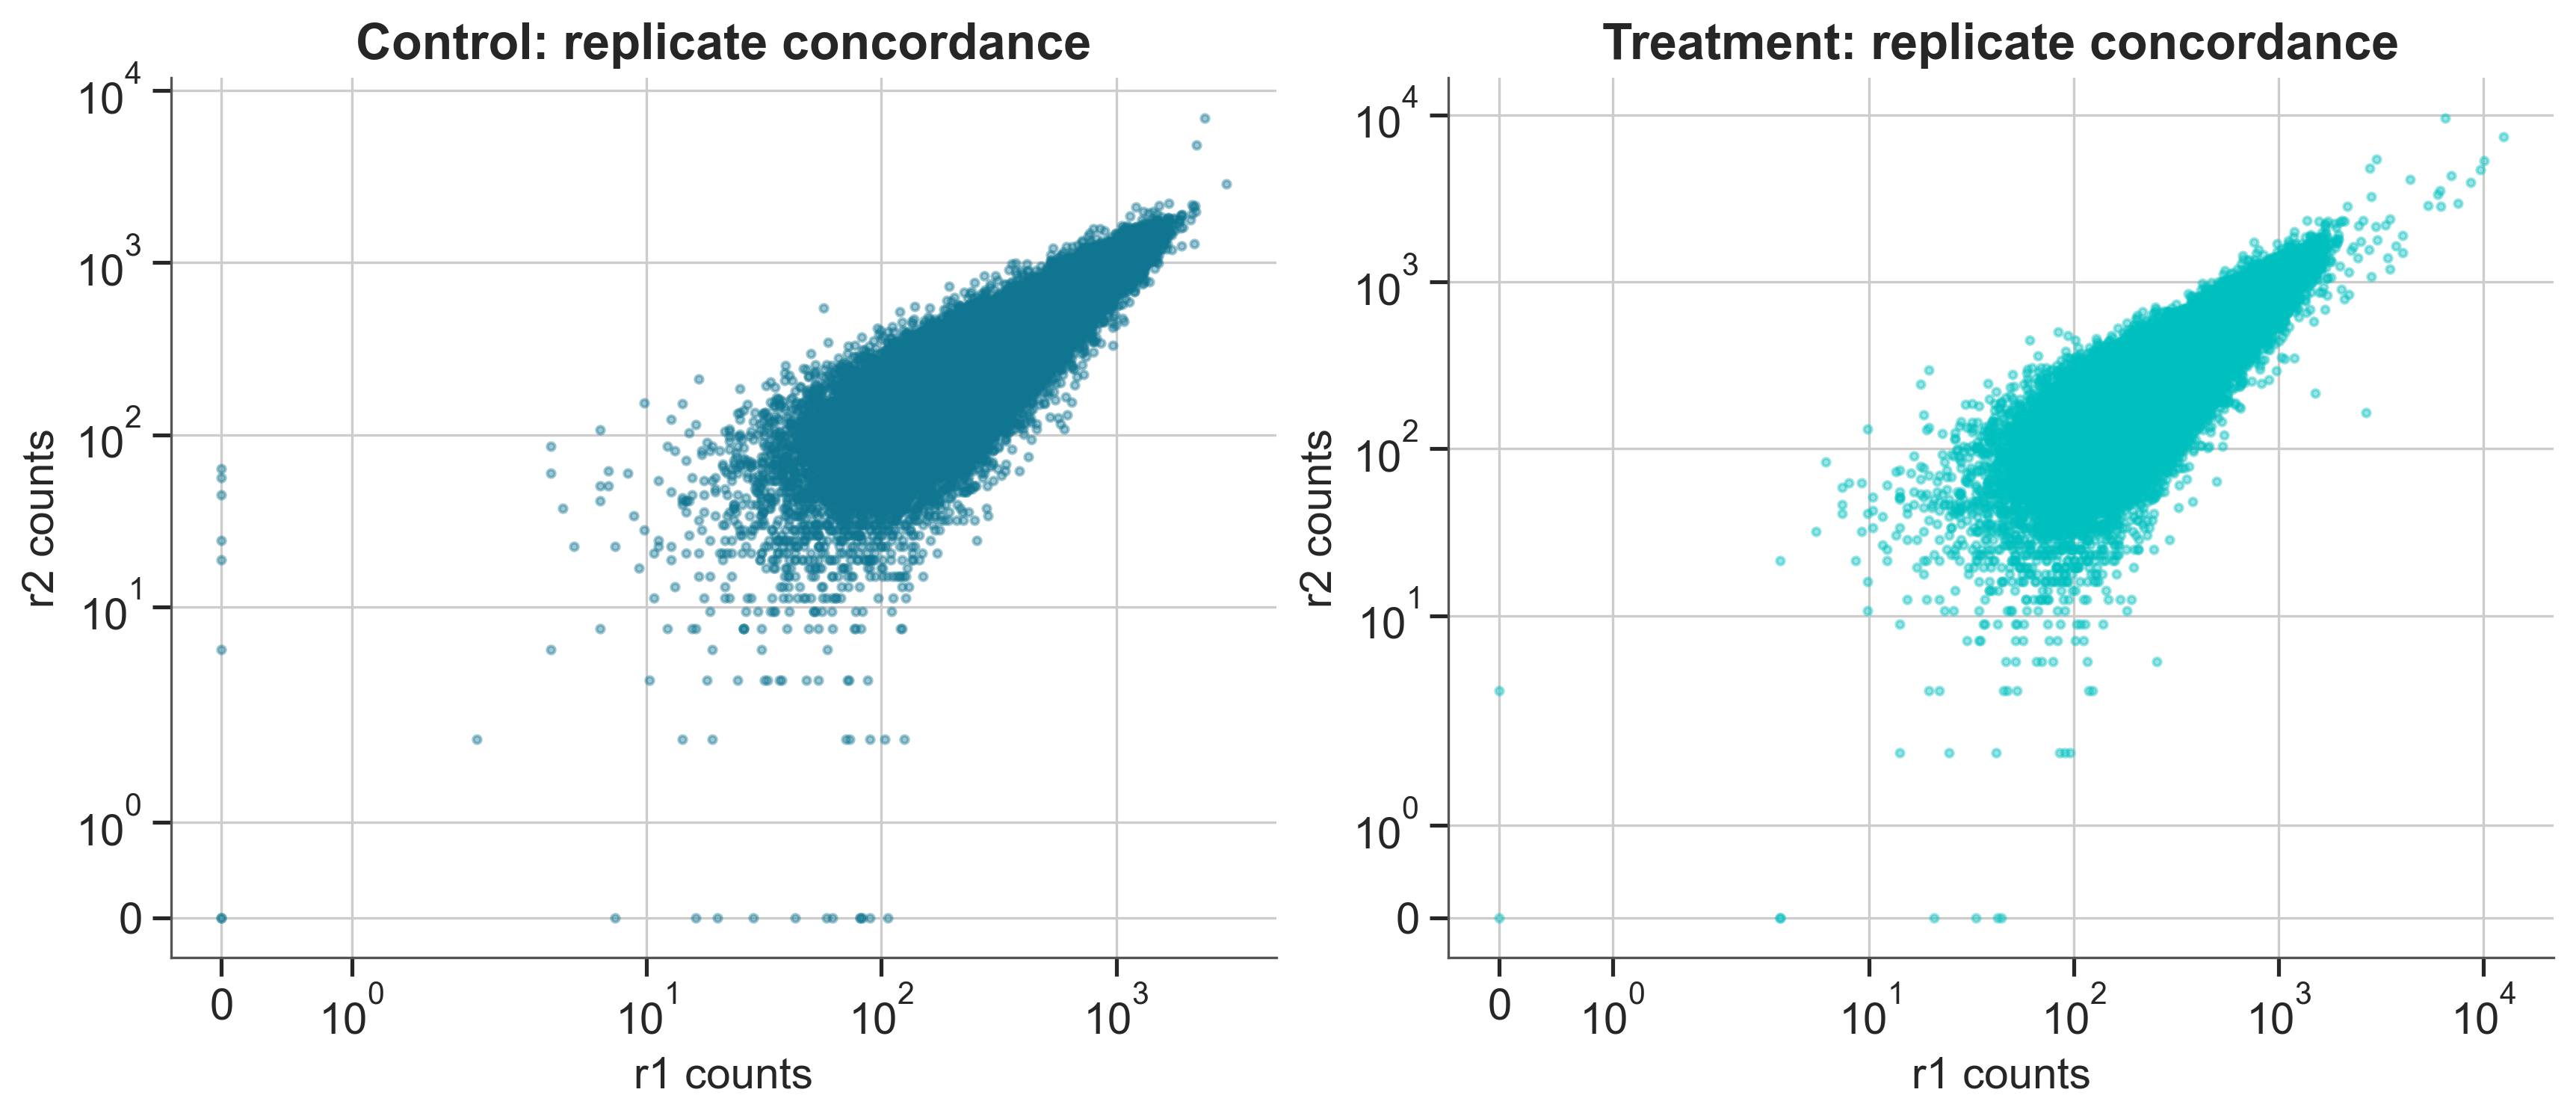

In [96]:
# QA/QC: replicate concordance (scatter) by condition
# Aggregate counts per sgRNA per replicate for each condition and plot r1 vs r2

# Control
ctrl = counts_long[counts_long['condition']=='control']
ctrl_pivot = ctrl.pivot_table(index=['sgrna','gene'], columns='replicate', values='count', aggfunc='sum')
ctrl_pivot.columns = [f'r{int(c)}' for c in ctrl_pivot.columns]

# Treatment
trt = counts_long[counts_long['condition']=='treatment']
trt_pivot = trt.pivot_table(index=['sgrna','gene'], columns='replicate', values='count', aggfunc='sum')
trt_pivot.columns = [f'r{int(c)}' for c in trt_pivot.columns]

fig, axes = plt.subplots(1, 2)

axes[0].scatter(ctrl_pivot['r1'], ctrl_pivot['r2'], s=6, alpha=0.4)
axes[0].set_xscale('symlog')
axes[0].set_yscale('symlog')
axes[0].set_title('Control: replicate concordance')
axes[0].set_xlabel('r1 counts')
axes[0].set_ylabel('r2 counts')

axes[1].scatter(trt_pivot['r1'], trt_pivot['r2'], s=6, alpha=0.4, color='C1')
axes[1].set_xscale('symlog')
axes[1].set_yscale('symlog')
axes[1].set_title('Treatment: replicate concordance')
axes[1].set_xlabel('r1 counts')
axes[1].set_ylabel('r2 counts')

plt.tight_layout()
# Save figure
fig_dir.mkdir(parents=True, exist_ok=True)
out_path_fig = fig_dir / 'qc_replicate_concordance.png'
fig.savefig(str(out_path_fig), dpi=150, bbox_inches='tight')
print(f'Saved figure: {out_path_fig}')
plt.show()

Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/qc_ecdf_counts.png


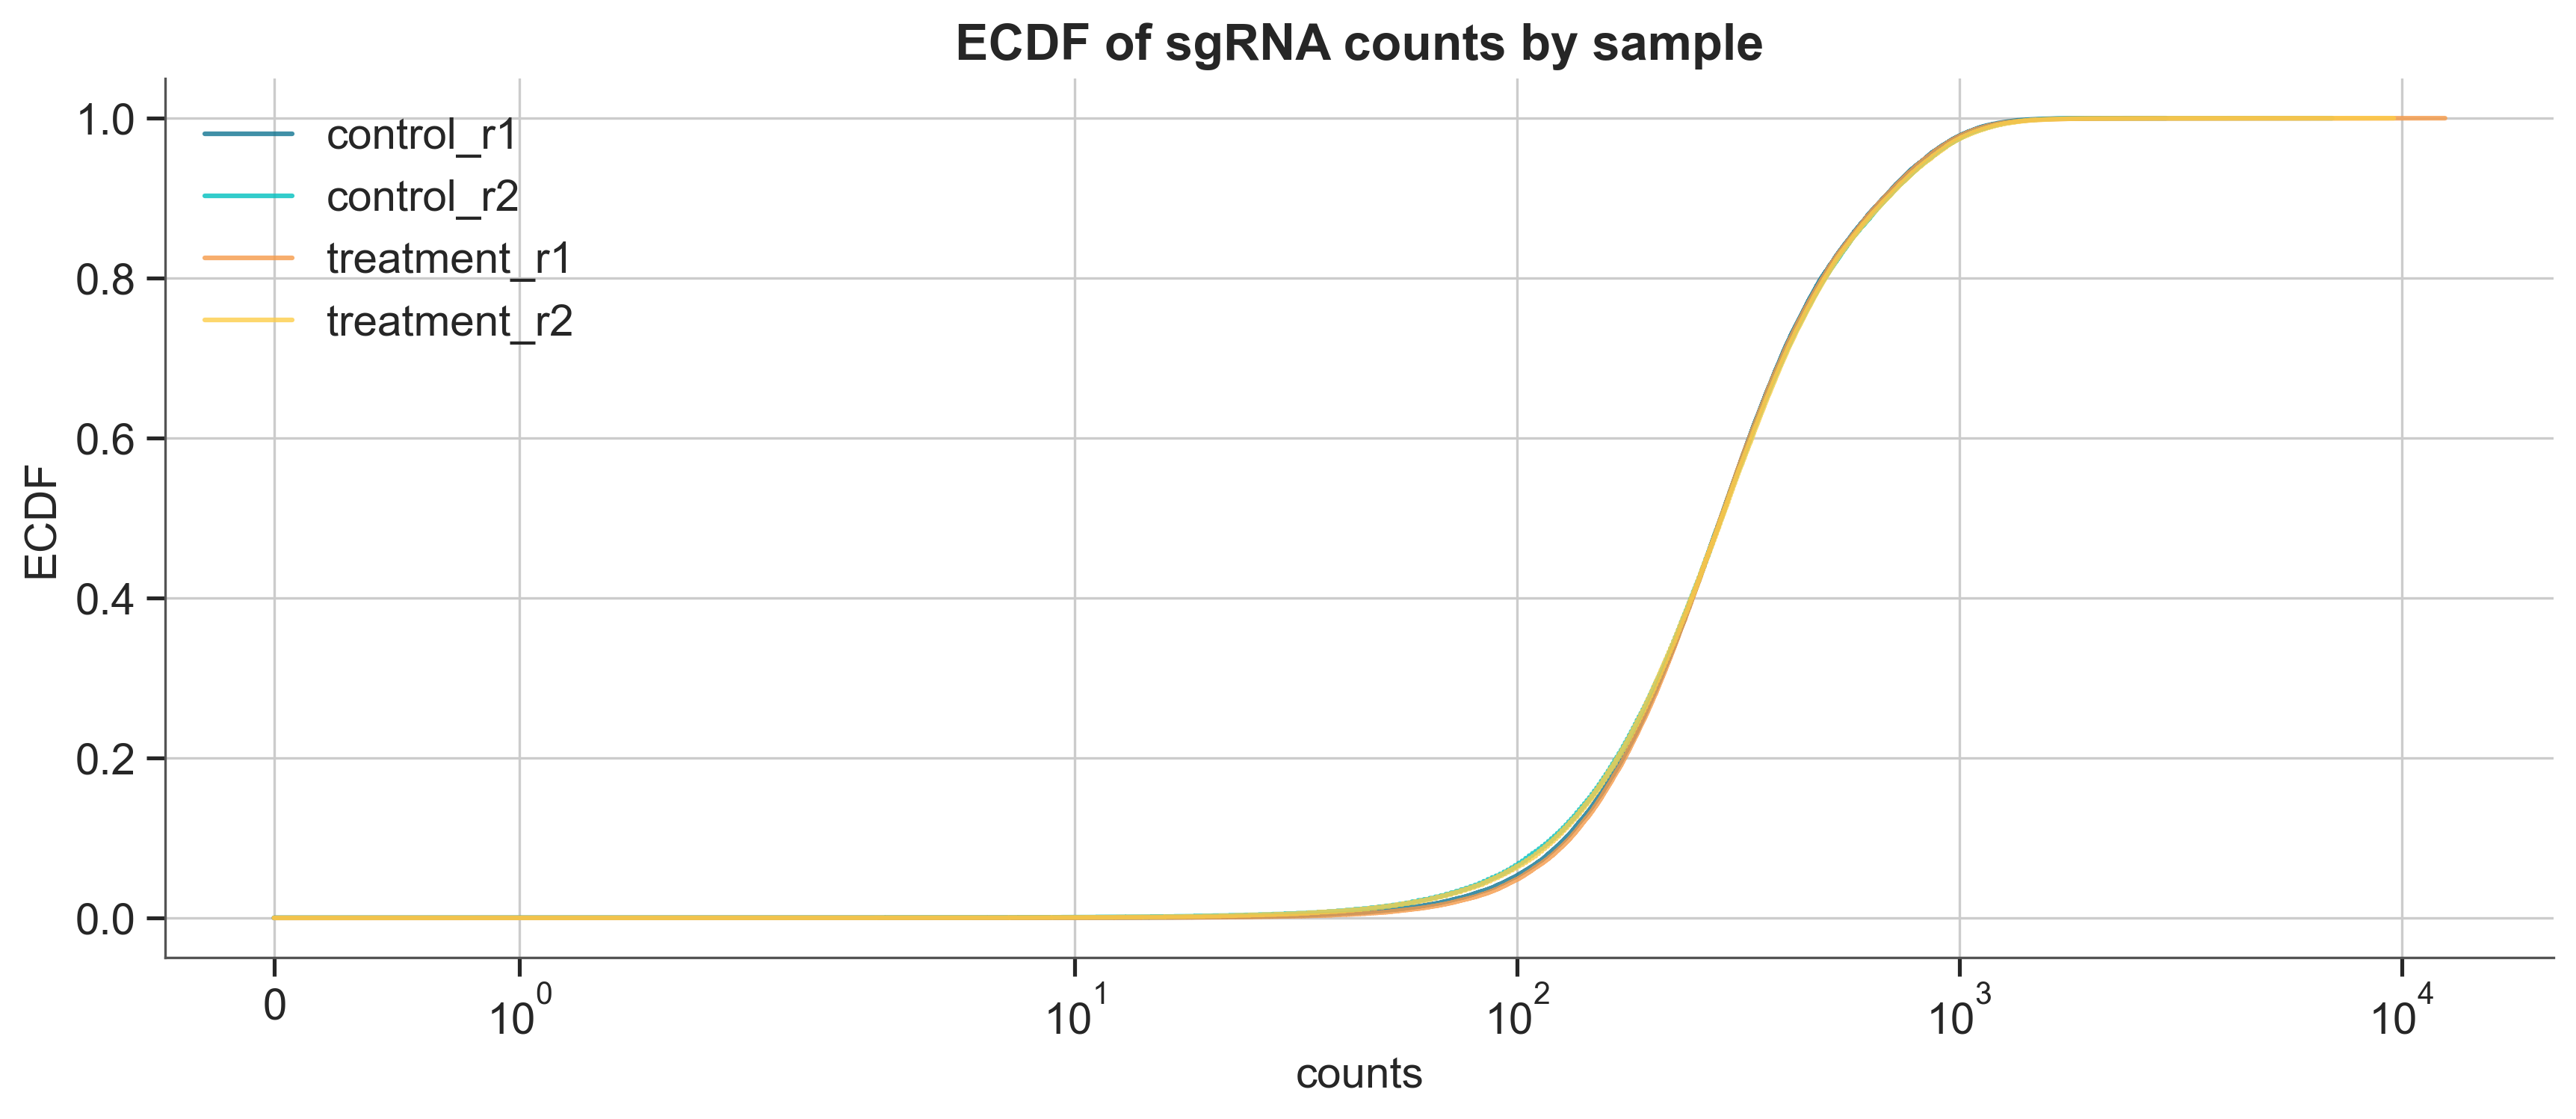

In [97]:
# QA/QC: sgRNA count distributions by sample (ECDF)
colors = {
    'control_r1': 'C0',
    'control_r2': 'C1',
    'treatment_r1': 'C2',
    'treatment_r2': 'C3',
}
for sid, grp in counts_long.groupby('sample_id'):
    x = np.sort(grp['count'].values)
    n = len(x)
    y = np.arange(1, n + 1) / n
    plt.plot(x, y, label=sid, color=colors.get(sid, None), alpha=0.8)

plt.xscale('symlog')
plt.xlabel('counts')
plt.ylabel('ECDF')
plt.title('ECDF of sgRNA counts by sample')
plt.legend()
plt.tight_layout()
# Save figure
fig_dir.mkdir(parents=True, exist_ok=True)
out_path_fig = fig_dir / 'qc_ecdf_counts.png'
plt.gcf().savefig(str(out_path_fig), dpi=150, bbox_inches='tight')
print(f'Saved figure: {out_path_fig}')
plt.show()

Saved figure: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/qc_hist_counts_by_sample.png


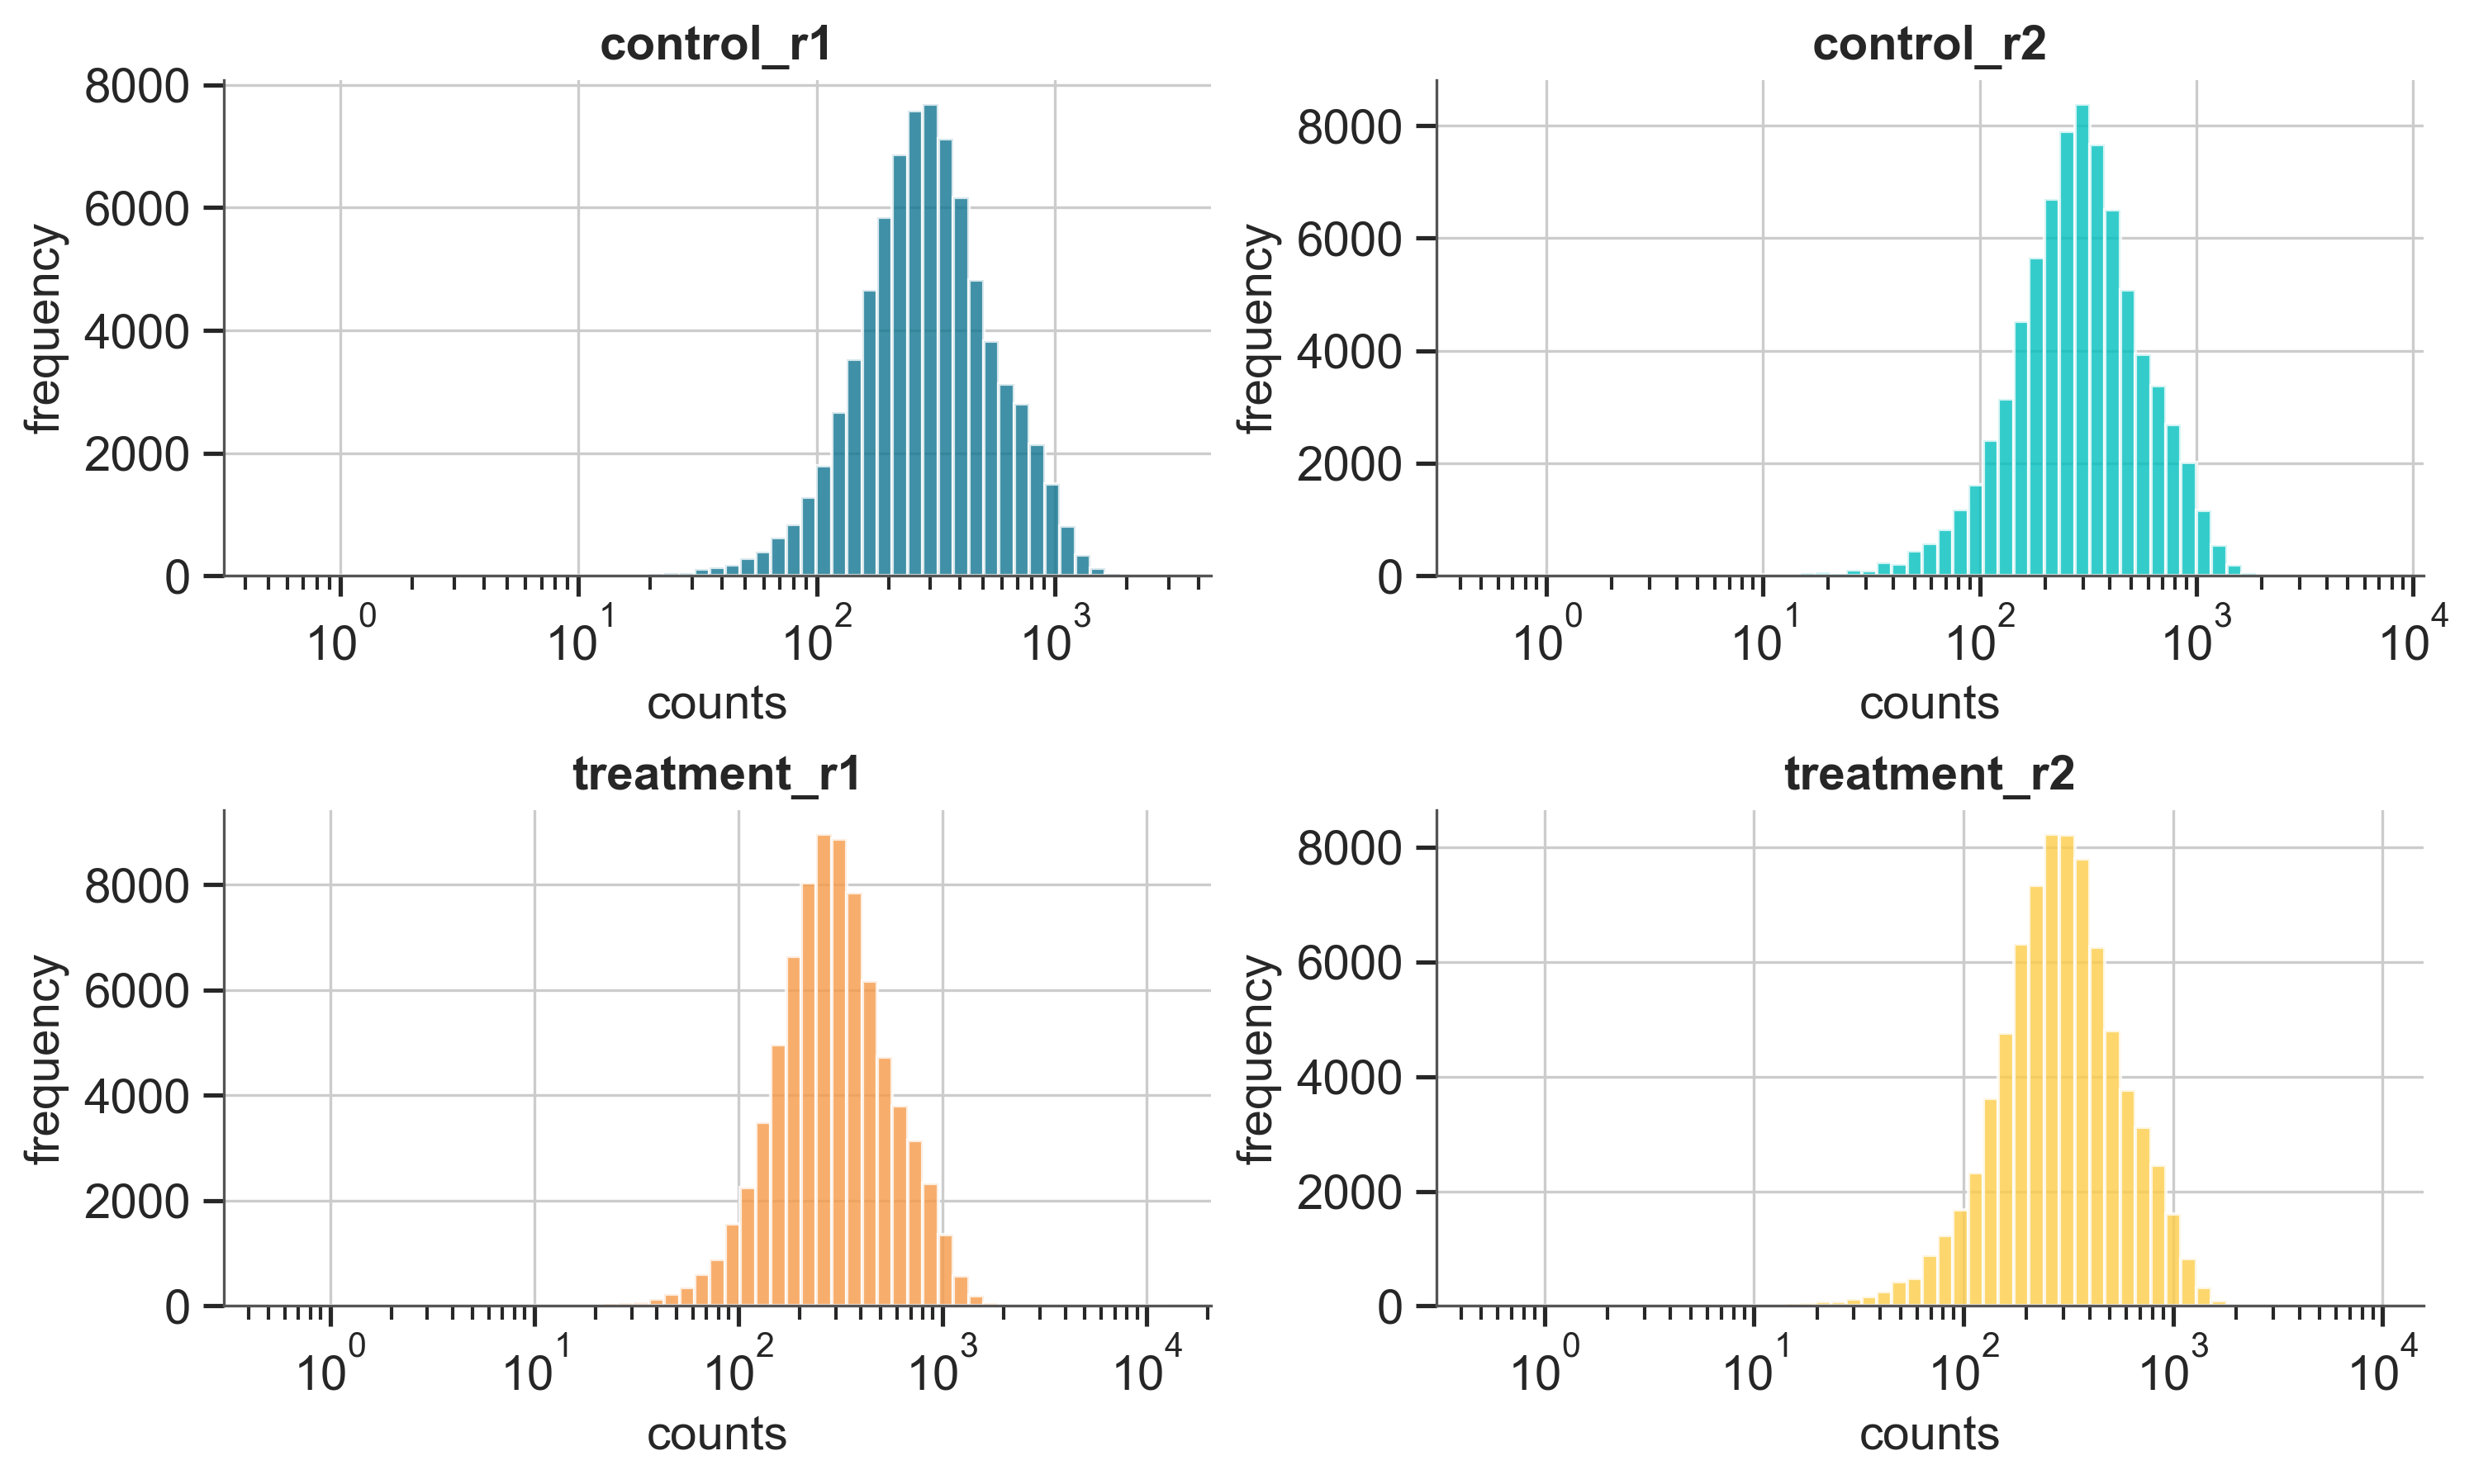

In [98]:
# QA/QC: Per-sample histograms of sgRNA counts (log-binned)
import math

samples = summary['sample_id'].tolist()
n = len(samples)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))
axes = axes.flatten() if n > 1 else [axes]

for i, sid in enumerate(samples):
    data = counts_long.loc[counts_long['sample_id'] == sid, 'count'].values
    # replace zeros with small positive to allow log bins
    data_plot = np.where(data <= 0, 0.5, data)
    max_val = max(1.0, data_plot.max())
    bins = np.logspace(math.log10(0.5), math.log10(max_val + 1.0), 60)
    axes[i].hist(data_plot, bins=bins, color=f'C{i}', alpha=0.8)
    axes[i].set_xscale('log')
    axes[i].set_title(sid, fontsize=14)
    axes[i].set_xlabel('counts')
    axes[i].set_ylabel('frequency')

# hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
# Save figure (single combined file)
fig_dir.mkdir(parents=True, exist_ok=True)
out_path_fig = fig_dir / 'qc_hist_counts_by_sample.png'
fig.savefig(str(out_path_fig), dpi=150, bbox_inches='tight')
print(f'Saved figure: {out_path_fig}')
plt.show()

## Normalization: library-size factors (current choice)

We use simple library-size normalization for now:
- For each sample, compute total sgRNA counts
- Compute the geometric mean of total counts across samples
- Define size_factor for a sample as total_count / geometric_mean
- Use log(size_factor) as an offset in GLMs and downstream models

Note: DESeq2 median-of-ratios produced size factors ≈ 1 across samples in this dataset, so it would have minimal impact. We can switch back to DESeq2 later if composition shifts are suspected.

## Stage-1: Fast screening

- Normalize counts using library-size size factors and use log(size_factor) as offset.
- Compute per-gene lightweight scores using only sgRNA counts:
  - baseMean of normalized counts
  - sgRNA LFC median, sign-consistency, MAD
  - simple NB/Poisson-GLM (non-hierarchical): Wald z/p for treatment effect
- Compose a rank: rank(p_Wald) + rank(-|median_LFC|) + rank(-sign_consistency)
- Use sample-split for guardrail: rep1 for screening, rep2 to confirm direction consistency
- Save:
  - outputs/tables/candidate_genes.csv
  - outputs/tables/tidy_counts_candidates.csv

In [80]:
# Stage-1 candidates from sgRNA counts (MAGeCK-free)
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats

# Inputs from earlier cells or define fallbacks
project_root = globals().get("project_root")
if project_root is None:
    project_root = Path.cwd().parents[2]

data_dir = globals().get("data_dir", project_root / "data")
table_dir = globals().get("table_dir", project_root / "outputs" / "tables")
fig_dir = globals().get("fig_dir", project_root / "outputs" / "figures")

table_dir.mkdir(parents=True, exist_ok=True)

# Expect counts_long to exist with updated DESeq2 size_factor
if 'counts_long' not in globals():
    raise RuntimeError("counts_long not found. Run tidy/QA cells first.")

# Parameters
C = 0.5  # pseudo-count for LFC
BASEMEAN_MIN = 10  # filter; relax to 5 if very sparse
TOP_K = 5000
BUFFER = 1000

# Build normalized counts per sample using DESeq2 size factors
counts_long = counts_long.copy()
counts_long['norm'] = counts_long['count'] / counts_long['size_factor']

# Split by replicate for sample-split guardrail (replicate is numeric: 1, 2)
rep1 = counts_long[counts_long['replicate'] == 1]
rep2 = counts_long[counts_long['replicate'] == 2]

# Helper to compute sgRNA-level LFC for a replicate-slice
def sgrna_lfc(df_slice: pd.DataFrame) -> pd.DataFrame:
    piv = df_slice.pivot_table(index=['sgrna','gene'], columns='condition', values='norm', aggfunc='sum').fillna(0.0)
    for col in ['control','treatment']:
        if col not in piv.columns:
            piv[col] = 0.0
    lfc = np.log2((piv['treatment'] + C) / (piv['control'] + C))
    return lfc.to_frame('lfc').reset_index()

lfc1 = sgrna_lfc(rep1)
lfc2 = sgrna_lfc(rep2)

# Per-gene aggregation
# - median LFC
# - MAD (Median Absolute Deviation): median(|x - median(x)|)
# - sign-consistency: share of sgRNAs whose sign matches gene-level median sign
# - n_sgrna: number of sgRNAs observed

def aggregate_gene_metrics(lfc_df: pd.DataFrame, label: str) -> pd.DataFrame:
    grp = lfc_df.groupby('gene')
    med = grp['lfc'].median().rename(f'median_lfc_{label}')
    # Robust MAD (median absolute deviation)
    mad_series = grp['lfc'].apply(lambda s: np.median(np.abs(s - np.median(s)))).rename(f'mad_lfc_{label}')
    # Gene-level median sign
    sign_med = np.sign(med).replace(0, 0)
    tmp = lfc_df.merge(sign_med.rename('sign_med'), left_on='gene', right_index=True, how='left')
    tmp['agree'] = np.sign(tmp['lfc']).replace(0, 0) == tmp['sign_med']
    sc = tmp.groupby('gene')['agree'].mean().rename(f'sign_consistency_{label}')
    n_sg = grp['lfc'].size().rename(f'n_sgrna_{label}')
    return pd.concat([med, mad_series, sc, n_sg], axis=1).reset_index()

agg1 = aggregate_gene_metrics(lfc1, 'r1')
agg2 = aggregate_gene_metrics(lfc2, 'r2')

# baseMean using normalized counts across both replicates and conditions
base = (
    counts_long
    .groupby(['gene','sgrna','sample_id'])['norm'].sum()
    .groupby('gene').mean()
    .rename('baseMean')
    .reset_index()
)

# Simple GLM per gene with Poisson link and offset log(size_factor)
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.tools import add_constant

wald_rows = []
for g, df in counts_long.groupby('gene'):
    try:
        X = pd.DataFrame({'treat': (df['condition'] == 'treatment').astype(int).values})
        X = add_constant(X, has_constant='add')
        y = df['count'].astype(float).values
        offset = np.log(df['size_factor'].values)
        model = GLM(y, X, family=families.Poisson(), offset=offset)
        res = model.fit(maxiter=50, disp=0)
        beta = res.params.get('treat', np.nan)
        se = res.bse.get('treat', np.nan)
        z = beta / se if (se is not None and se > 0) else np.nan
        p = 2 * (1 - stats.norm.cdf(abs(z))) if np.isfinite(z) else 1.0
        wald_rows.append({'gene': g, 'wald_beta': beta, 'wald_se': se, 'wald_z': z, 'wald_p': p})
    except Exception:
        wald_rows.append({'gene': g, 'wald_beta': np.nan, 'wald_se': np.nan, 'wald_z': np.nan, 'wald_p': 1.0})

wald = pd.DataFrame(wald_rows)

# Merge all metrics
metrics = base.merge(agg1, on='gene', how='left').merge(agg2, on='gene', how='left').merge(wald, on='gene', how='left')

# Primary metrics for ranking
metrics['n_sgrna'] = metrics[['n_sgrna_r1','n_sgrna_r2']].fillna(0).max(axis=1)
metrics['median_lfc'] = metrics[['median_lfc_r1','median_lfc_r2']].median(axis=1)
metrics['sign_consistency'] = metrics[['sign_consistency_r1','sign_consistency_r2']].median(axis=1)
metrics['mad_lfc'] = metrics[['mad_lfc_r1','mad_lfc_r2']].median(axis=1)

# Filters
keep = (metrics['baseMean'] >= BASEMEAN_MIN) & (metrics['n_sgrna'] >= 3)
metrics_f = metrics.loc[keep].copy()

# Composite rank (lower is better)
metrics_f['rank_p'] = metrics_f['wald_p'].rank(method='average')
metrics_f['rank_lfc'] = (-metrics_f['median_lfc'].abs()).rank(method='average')
metrics_f['rank_sc'] = (-metrics_f['sign_consistency']).rank(method='average')
metrics_f['composite_rank'] = metrics_f[['rank_p','rank_lfc','rank_sc']].sum(axis=1)

# Sample-split confirmation: direction consistency on rep2
metrics_f['confirm_sign_consistency'] = metrics_f['sign_consistency_r2']

# Select 
# 
# 
# 
#  K + buffer
K = TOP_K + BUFFER
candidates = metrics_f.sort_values('composite_rank').head(K).copy()

# Save candidate table
out_cand = table_dir / 'candidate_genes.csv'
candidates_cols = [
    'gene','baseMean','n_sgrna','median_lfc','sign_consistency','mad_lfc',
    'wald_beta','wald_se','wald_z','wald_p','composite_rank','confirm_sign_consistency'
]
candidates[candidates_cols].to_csv(out_cand, index=False)
print(f"Saved candidate genes: {out_cand} (n={len(candidates)})")

Saved candidate genes: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/candidate_genes.csv (n=6000)


In [81]:
# Restrict tidy counts to Stage-1 candidates and save
import pandas as pd

if 'counts_long' not in globals():
    raise RuntimeError("counts_long not found. Run tidy/QA cells first.")

cand_df = pd.read_csv(table_dir / "candidate_genes.csv")
keep_genes = set(cand_df['gene'].unique())
counts_candidates = counts_long[counts_long['gene'].isin(keep_genes)].copy()

out_tidy_cand = table_dir / "tidy_counts_candidates.csv"
counts_candidates.to_csv(out_tidy_cand, index=False)
print(f"Saved candidate tidy counts: {out_tidy_cand} (rows={len(counts_candidates):,})")

Saved candidate tidy counts: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/tidy_counts_candidates.csv (rows=96,216)


## Stage-2: Bayesian hierarchical modeling (NB; VI-first, improved)

We fit a per-gene hierarchical Negative Binomial model with sgRNA random effects, centered treatment coding, and sample (replicate×condition) effects:
- Observation: y ~ NegBinom(mu, phi), Var[y] = mu + mu^2/phi
- Link: log(mu) = log(size_factor) + alpha + beta * I_centered[treatment] + u_sgRNA + gamma_sample (sum-to-zero)
- Priors: alpha ~ N(0,2), beta ~ StudentT(ν=3, 0, 1), u ~ N(0, tau_u), tau_u ~ HalfNormal(1), phi ~ HalfNormal(2), gamma_raw ~ N(0,0.5) then gamma = gamma_raw - mean(gamma_raw)
- Inference: VI (ADVI) first; optionally short MCMC for top hits
- Decision: compute PSP = P(beta>0) and lfsr = min(P(beta>0), P(beta<0))

We save:
- outputs/tables/bayes_gene_summary_nb_vi.csv (beta mean/sd, PSP, lfsr, etc.)
- outputs/tables/bayes_sgrna_effects_nb_vi.csv (per-sgRNA random effects summary)

In [ ]:
# Stage-2 (NB improved): centered coding + sample effects; VI then optional short NUTS
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

TOPN_STAGE2 = 200
np.random.seed(42)

cand_df = pd.read_csv(table_dir / 'candidate_genes.csv')
sel_genes = list(cand_df.sort_values('composite_rank').head(TOPN_STAGE2)['gene'].unique())

def build_df(g):
    d = counts_candidates[counts_candidates['gene'] == g].copy()
    d['treat_c'] = ((d['condition'] == 'treatment').astype(int) - 0.5).astype(float)  # -0.5 / +0.5
    d['offset'] = np.log(d['size_factor'].values)
    return d

gene_rows = []
for gene in sel_genes:
    d = build_df(gene)
    if d.empty:
        continue
    y = d['count'].astype(int).values
    x = d['treat_c'].values
    sample_idx, sample_uni = pd.factorize(d['sample_id'], sort=True)

    with pm.Model() as m:
        alpha = pm.Normal('alpha', 0.0, 2.0)
        beta = pm.StudentT('beta', nu=3, mu=0.0, sigma=1.0)  # heavier-tailed, symmetric
        # sample effects (sum-to-zero)
        gamma = pm.Normal('gamma', 0.0, 1.0, shape=len(sample_uni))
        gamma_c = gamma - pm.math.mean(gamma)
        phi = pm.HalfNormal('phi', 2.5)

        eta = alpha + beta * x + gamma_c[sample_idx] + d['offset'].values
        mu = pm.math.exp(eta)

        pm.NegativeBinomial('y', mu=mu, alpha=phi, observed=y)

        approx = pm.fit(6000, method='advi',
                        obj_optimizer=pm.adam(learning_rate=5e-3),
                        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-3)])
        idata_vi = approx.sample(1000)

    beta_draws = az.extract(idata_vi, var_names=['beta']).to_dataframe()['beta'].values
    p_pos = float(np.mean(beta_draws > 0))
    p_neg = 1.0 - p_pos
    lfsr = float(min(p_pos, p_neg))
    summ = az.summary(idata_vi, var_names=['alpha','beta','phi'])

    gene_rows.append({
        'gene': gene,
        'beta_mean': float(summ.loc['beta','mean']),
        'beta_sd': float(summ.loc['beta','sd']),
        'phi_mean': float(summ.loc['phi','mean']),
        'psp': p_pos,
        'lfsr': lfsr
    })

out_gene = table_dir / 'bayes_gene_summary_nb_improved_vi.csv'
pd.DataFrame(gene_rows).to_csv(out_gene, index=False)
print(f"Saved NB (improved) summaries: {out_gene}")

## Stage-2 (alternative): Paired Beta–Binomial on treatment share (VI-first)

We model the treatment share per sgRNA using a paired Beta–Binomial, which can be more robust to NB misspecification when total counts per sgRNA vary widely:
- Data: for each sgRNA×replicate, y = treatment_count, n = treatment+control total
- Link: logit(p) = δ_gene + u_sgRNA + γ_replicate (sum-to-zero)
- Likelihood: y ~ BetaBinomial(n=n, p=p, conc=conc)
- Priors: δ ~ StudentT(ν=3,0,1), u ~ N(0, τ_u), τ_u ~ HalfNormal(1), γ_raw ~ N(0,0.5), conc ~ HalfNormal(5)
- Inference: VI (ADVI) first; decision with PSP/lfsr on δ

We save:
- outputs/tables/bayes_gene_summary_bb_vi.csv
- outputs/tables/bayes_sgrna_effects_bb_vi.csv

In [ ]:
# Stage-2 (alternative): Paired Beta-Binomial on treatment share (VI-first)
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

TOPN_STAGE2 = 200  # genes to run
np.random.seed(42)

# Build per-(gene, sgrna, replicate) paired counts: y=treatment, n=control+treatment
pairs = (
    counts_candidates
    .pivot_table(index=['gene','sgrna','replicate'], columns='condition', values='count', aggfunc='sum')
    .reset_index()
)
pairs = pairs.dropna(subset=['control','treatment']).copy()
pairs['y'] = pairs['treatment'].astype(int)
pairs['n'] = (pairs['control'] + pairs['treatment']).astype(int)

# Select genes
cand_df = pd.read_csv(table_dir / 'candidate_genes.csv')
sel_genes = list(cand_df.sort_values('composite_rank').head(TOPN_STAGE2)['gene'].unique())
print(f"Beta-Binomial Stage-2: running {len(sel_genes)} genes")

gene_rows = []
sgrna_rows = []

for gene in sel_genes:
    d = pairs[pairs['gene'] == gene].copy()
    if d.empty:
        continue
    sg_idx, sg_uni = pd.factorize(d['sgrna'], sort=True)
    rep_idx, rep_uni = pd.factorize(d['replicate'], sort=True)
    y = d['y'].values
    n = d['n'].values

    with pm.Model() as m:
        # delta: gene-level shift of logit treatment share (0 => p=0.5)
        delta = pm.StudentT('delta', nu=3, mu=0.0, sigma=1.0)
        # sgRNA random effects
        tau_u = pm.HalfNormal('tau_u', sigma=1.0)
        u = pm.Normal('u', mu=0.0, sigma=tau_u, shape=len(sg_uni))
        # replicate effects (sum-to-zero centered)
        gamma = pm.Normal('gamma', mu=0.0, sigma=1.0, shape=len(rep_uni))
        gamma_c = gamma - pm.math.mean(gamma)

        eta = delta + u[sg_idx] + gamma_c[rep_idx]
        p = pm.math.sigmoid(eta)

        # Overdispersion across pairs via Beta-Binomial concentration
        conc = pm.HalfNormal('conc', sigma=5.0)
        pm.BetaBinomial('y', n=n, alpha=p * conc, beta=(1 - p) * conc, observed=y)

        approx = pm.fit(6000, method='advi',
                        obj_optimizer=pm.adam(learning_rate=5e-3),
                        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-3)])
        idata_vi = approx.sample(1000)

    # Gene summary
    summ = az.summary(idata_vi, var_names=['delta','tau_u','conc'])
    delta_draws = az.extract(idata_vi, var_names=['delta']).to_dataframe()['delta'].values
    p_pos = float(np.mean(delta_draws > 0))
    p_neg = 1.0 - p_pos
    lfsr = float(min(p_pos, p_neg))

    gene_rows.append({
        'gene': gene,
        'delta_mean': float(summ.loc['delta','mean']),
        'delta_sd': float(summ.loc['delta','sd']),
        'tau_u_mean': float(summ.loc['tau_u','mean']),
        'conc_mean': float(summ.loc['conc','mean']),
        'psp': p_pos,
        'lfsr': lfsr
    })

    # sgRNA effects (optional)
    if 'u' in idata_vi.posterior:
        u_means = idata_vi.posterior['u'].mean(dim=('chain','draw')).values
        for i, sg in enumerate(sg_uni):
            sgrna_rows.append({'gene': gene, 'sgrna': sg, 'u_mean': float(u_means[i])})

# Save
out_gene = table_dir / 'bayes_gene_summary_bb_vi.csv'
out_sg = table_dir / 'bayes_sgrna_effects_bb_vi.csv'
pd.DataFrame(gene_rows).to_csv(out_gene, index=False)
pd.DataFrame(sgrna_rows).to_csv(out_sg, index=False)
print(f"Saved Beta-Binomial summaries: {out_gene}, {out_sg}")

## Stage-2 (alternative): Poisson–Lognormal on log mean (VI-first)

We model overdispersion via a lognormal random effect on the Poisson mean:
- Likelihood: y ~ Poisson(lambda)
- Link: log(lambda) = log(size_factor) + alpha + beta * I_centered[treatment] + gamma_sample + eps
- Random log effect: eps ~ Normal(0, sigma_log)
- Priors: beta ~ StudentT(ν=3, 0, 1), sigma_log ~ HalfNormal(1.0), gamma centered to sum-to-zero
- Inference: VI-first (ADVI); save PSP/lfsr for beta

Outputs:
- outputs/tables/bayes_gene_summary_pl_vi.csv

In [ ]:
# Stage-2 (alternative): Poisson–Lognormal (PL) via VI
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# Config
TOPN_STAGE2 = 200
np.random.seed(42)

# Select genes by composite_rank
cand_df = pd.read_csv(table_dir / 'candidate_genes.csv')
sel_genes = list(cand_df.sort_values('composite_rank').head(TOPN_STAGE2)['gene'].unique())
print(f"Poisson–Lognormal Stage-2: running {len(sel_genes)} genes")

gene_rows = []

for gene in sel_genes:
    d = counts_candidates[counts_candidates['gene'] == gene].copy()
    if d.empty:
        continue

    # Centered treatment coding and sample effects
    d['treat_c'] = ((d['condition'] == 'treatment').astype(int) - 0.5).astype(float)
    d['offset'] = np.log(d['size_factor'].values)
    sample_idx, sample_uni = pd.factorize(d['sample_id'], sort=True)

    y = d['count'].astype(int).values
    x = d['treat_c'].values

    with pm.Model() as m:
        alpha = pm.Normal('alpha', 0.0, 2.0)
        beta = pm.StudentT('beta', nu=3, mu=0.0, sigma=1.0)
        gamma = pm.Normal('gamma', 0.0, 1.0, shape=len(sample_uni))
        gamma_c = pm.Deterministic('gamma_c', gamma - pm.math.mean(gamma))
        sigma_log = pm.HalfNormal('sigma_log', 1.0)

        # Lognormal random effect per observation
        eps = pm.Normal('eps', 0.0, sigma_log, shape=len(y))

        eta = alpha + beta * x + gamma_c[sample_idx] + d['offset'].values + eps
        lam = pm.Deterministic('lambda', pm.math.exp(eta))

        pm.Poisson('y', mu=lam, observed=y)

        approx = pm.fit(6000, method='advi', obj_optimizer=pm.adam(learning_rate=5e-3), callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-3)])
        idata_vi = approx.sample(1000)

    # Posterior sign probability and lfsr for beta
    beta_draws = az.extract(idata_vi, var_names=['beta']).to_dataframe()['beta'].values
    p_pos = float(np.mean(beta_draws > 0))
    p_neg = 1.0 - p_pos
    lfsr = float(min(p_pos, p_neg))
    summ = az.summary(idata_vi, var_names=['alpha','beta','sigma_log'])

    gene_rows.append({
        'gene': gene,
        'beta_mean': float(summ.loc['beta','mean']),
        'beta_sd': float(summ.loc['beta','sd']),
        'sigma_log_mean': float(summ.loc['sigma_log','mean']),
        'psp': p_pos,
        'lfsr': lfsr
    })

# Save
out_gene = table_dir / 'bayes_gene_summary_pl_vi.csv'
pd.DataFrame(gene_rows).to_csv(out_gene, index=False)
print(f"Saved PL summaries: {out_gene}")

## Stage-2 (joint): Hierarchical multi-gene NB with explicit condition contrast

We fit a single joint NB model over the top-N genes with an explicit condition contrast per gene:
- Observation: y ~ NegBinom(mu, phi)
- Link: log(mu) = log(size_factor) + gamma_g + beta_g * I_centered[treatment] + u_sgRNA + r_sample
- Priors: gamma_g ~ N(0, 1.5); beta_g uses global-shrinkage (StudentT or Normal with HalfNormal global scale); u_sgRNA ~ N(0, tau_u); r centered to sum-to-zero; phi ~ HalfNormal
- Inference: VI-first (ADVI); decision via PSP/lfsr on beta_g

Outputs:
- outputs/tables/bayes_gene_summary_nb_joint_vi.csv (beta_g, PSP, lfsr)
- outputs/tables/bayes_sgrna_effects_nb_joint_vi.csv (optional u_sgRNA)

In [119]:
# Stage-2 (joint): Multi-gene NB with explicit condition contrast via VI
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# Config
TOPN_STAGE2 = 200
np.random.seed(42)

cand_df = pd.read_csv(table_dir / 'candidate_genes.csv')
sel_genes = list(cand_df.sort_values('composite_rank').head(TOPN_STAGE2)['gene'].unique())
print(f"Joint NB model: building matrix for {len(sel_genes)} genes")

# Build a single design matrix across selected genes
D = counts_candidates[counts_candidates['gene'].isin(sel_genes)].copy()
D['treat_c'] = ((D['condition'] == 'treatment').astype(int) - 0.5).astype(float)
D['offset'] = np.log(D['size_factor'].values)

# Indexers
gene_idx, gene_uni = pd.factorize(D['gene'], sort=True)
sg_idx, sg_uni = pd.factorize(D['sgrna'], sort=True)
sample_idx, sample_uni = pd.factorize(D['sample_id'], sort=True)

y = D['count'].astype(int).values
x = D['treat_c'].values
G = len(gene_uni)
S = len(sg_uni)
R = len(sample_uni)
N = len(y)
print(f"N={N}, Genes={G}, sgRNAs={S}, Samples={R}")

with pm.Model() as m:
    # Gene baselines and contrast
    gamma_g = pm.Normal('gamma_g', 0.0, 1.5, shape=G)
    # Global-local shrinkage for beta_g (simplified): beta_g ~ Normal(0, tau_beta)
    tau_beta = pm.HalfNormal('tau_beta', 1.0)
    beta_g = pm.Normal('beta_g', 0.0, tau_beta, shape=G)

    # sgRNA random effects (partial pooling across all sgRNAs)
    tau_u = pm.HalfNormal('tau_u', 1.0)
    u = pm.Normal('u', 0.0, tau_u, shape=S)

    # Sample effects (centered to sum-to-zero)
    r_raw = pm.Normal('r_raw', 0.0, 0.5, shape=R)
    r = pm.Deterministic('r', r_raw - pm.math.mean(r_raw))

    # Overdispersion (NB2)
    phi = pm.HalfNormal('phi', 2.0)

    eta = (
        D['offset'].values
        + gamma_g[gene_idx]
        + beta_g[gene_idx] * x
        + u[sg_idx]
        + r[sample_idx]
    )
    mu = pm.math.exp(eta)

    pm.NegativeBinomial('y', mu=mu, alpha=phi, observed=y)

    approx = pm.fit(6000, method='advi', obj_optimizer=pm.adam(learning_rate=5e-3), callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-3)])
    idata_vi = approx.sample(1000)

# Summaries per gene (beta_g) — robust across PyMC/ArviZ versions
# Extract posterior draws for beta_g without relying on column names
if 'beta_g' not in idata_vi.posterior:
    raise RuntimeError("beta_g not found in posterior draws for joint NB model")

beta_vals = idata_vi.posterior['beta_g'].values
# Shapes can be (chains, draws, G) or (chains, draws) if G==1 with squeezed dim
if beta_vals.ndim == 3:
    C, D, G_ = beta_vals.shape
    flat = beta_vals.reshape(C * D, G_)
elif beta_vals.ndim == 2:
    # Assume single gene case, squeeze to column vector
    flat = beta_vals.reshape(-1, 1)
    G_ = 1
else:
    flat = beta_vals.reshape(-1, 1)
    G_ = 1

# If shape mismatch occurs, fall back to ArviZ summary mapping by index
if G_ != G:
    post = az.summary(idata_vi, var_names=['beta_g'])
    post = post.reset_index().rename(columns={'index': 'param'})
    post['gene_idx'] = post['param'].str.extract(r'(\d+)').astype(int)
    post = post.merge(pd.DataFrame({'gene_idx': np.arange(G), 'gene': gene_uni}), on='gene_idx', how='right')
    post['psp'] = np.nan
    post['lfsr'] = np.nan
    out_gene = table_dir / 'bayes_gene_summary_nb_joint_vi.csv'
    post[['gene','mean','sd','psp','lfsr']].rename(columns={'mean':'beta_mean','sd':'beta_sd'}).to_csv(out_gene, index=False)
    print(f"Saved joint NB summaries (fallback mapping): {out_gene}")
else:
    means = flat.mean(axis=0)
    sds = flat.std(axis=0, ddof=1)
    psp_vals = (flat > 0).mean(axis=0)
    lfsr_vals = np.minimum(psp_vals, 1.0 - psp_vals)

    out_df = pd.DataFrame({
        'gene': gene_uni,
        'beta_mean': means.astype(float),
        'beta_sd': sds.astype(float),
        'psp': psp_vals.astype(float),
        'lfsr': lfsr_vals.astype(float),
    })
    out_gene = table_dir / 'bayes_gene_summary_nb_joint_vi.csv'
    out_df.to_csv(out_gene, index=False)
    print(f"Saved joint NB summaries: {out_gene}")

Joint NB model: building matrix for 200 genes
N=3384, Genes=200, sgRNAs=846, Samples=4


Output()

Finished [100%]: Average Loss = 27,212


Saved joint NB summaries: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bayes_gene_summary_nb_joint_vi.csv


# Hit selection per model with lfsr ≤ 0.1

In [120]:
# Hit selection per model with lfsr ≤ 0.1

TH = 0.1
th_str = str(TH).replace('.', '_')

models = [
    {'name': 'nb_improved', 'path': table_dir / 'bayes_gene_summary_nb_improved_vi.csv', 'effect': 'beta_mean'},
    {'name': 'bb',          'path': table_dir / 'bayes_gene_summary_bb_vi.csv',          'effect': 'delta_mean'},
    {'name': 'pl',          'path': table_dir / 'bayes_gene_summary_pl_vi.csv',          'effect': 'beta_mean'},
    {'name': 'nb_joint',    'path': table_dir / 'bayes_gene_summary_nb_joint_vi.csv',    'effect': 'beta_mean'},
]

hits_dict = {}
for m in models:
    if not m['path'].exists():
        print(f"Skip {m['name']}: missing {m['path']}")
        continue
    df = pd.read_csv(m['path'])
    if 'lfsr' not in df.columns:
        print(f"Skip {m['name']}: lfsr not found")
        continue

    hits = df[df['lfsr'] <= TH].copy()
    if m['effect'] in hits.columns:
        hits['abs_effect'] = hits[m['effect']].abs()
        hits = hits.sort_values(['lfsr', 'abs_effect'], ascending=[True, False])
    else:
        hits = hits.sort_values('lfsr')

    out = table_dir / f"hits_{m['name']}_lfsr_le_{th_str}.csv"
    keep_cols = ['gene']
    if m['effect'] in hits.columns: keep_cols.append(m['effect'])
    keep_cols += [c for c in ['psp', 'lfsr'] if c in hits.columns]
    hits[keep_cols].to_csv(out, index=False)
    print(f"Saved {m['name']} hits (n={len(hits)}): {out}")

    hits_dict[m['name']] = set(hits['gene'])

# Union / intersection / indicator summary
if hits_dict:
    union_genes = sorted(set().union(*hits_dict.values())) if hits_dict else []
    inter_genes = sorted(set.intersection(*[s for s in hits_dict.values()])) if len(hits_dict) > 1 else union_genes

    pd.DataFrame({'gene': union_genes}).to_csv(table_dir / f"hits_union_lfsr_le_{th_str}.csv", index=False)
    pd.DataFrame({'gene': inter_genes}).to_csv(table_dir / f"hits_intersection_lfsr_le_{th_str}.csv", index=False)

    summary = pd.DataFrame({'gene': union_genes})
    for name, genes in hits_dict.items():
        summary[name] = summary['gene'].isin(genes).astype(int)
    summary['n_models'] = summary[[k for k in hits_dict.keys()]].sum(axis=1)
    summary.sort_values(['n_models', 'gene'], ascending=[False, True]).to_csv(
        table_dir / f"hits_summary_lfsr_le_{th_str}.csv", index=False
    )

    print(f"Union hits: {len(union_genes)}, Intersection hits: {len(inter_genes)}")

Saved nb_improved hits (n=14): /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hits_nb_improved_lfsr_le_0_1.csv
Saved bb hits (n=199): /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hits_bb_lfsr_le_0_1.csv
Saved pl hits (n=200): /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hits_pl_lfsr_le_0_1.csv
Saved nb_joint hits (n=64): /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hits_nb_joint_lfsr_le_0_1.csv
Union hits: 200, Intersection hits: 12


## Results overview and model comparison (hits and overlaps)

This section compiles all Stage-2 model outputs, applies the hit rule (lfsr ≤ 0.1), and produces:
- Per-model hit counts and a combined wide table
- Overlap visualization (UpSet-style if available) and top intersections table
- Heatmaps of effect sizes and PSP across models for the union of hits
- Pairwise scatter plots comparing effect sizes across models

Outputs are written under `outputs/tables/` and `outputs/figures/`.

In [121]:
# Compile outputs and generate comparison tables/figures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

TH = 0.1
th_str = str(TH).replace('.', '_')

# Load per-model summaries (skip if missing)
model_specs = {
    'nb_improved': {'path': table_dir / 'bayes_gene_summary_nb_improved_vi.csv', 'effect': 'beta_mean'},
    'bb':          {'path': table_dir / 'bayes_gene_summary_bb_vi.csv',          'effect': 'delta_mean'},
    'pl':          {'path': table_dir / 'bayes_gene_summary_pl_vi.csv',          'effect': 'beta_mean'},
    'nb_joint':    {'path': table_dir / 'bayes_gene_summary_nb_joint_vi.csv',    'effect': 'beta_mean'},
}

summaries = {}
for name, spec in model_specs.items():
    p = spec['path']
    if p.exists():
        df = pd.read_csv(p)
        # normalize columns
        if 'gene' not in df.columns:
            print(f"Skip {name}: no gene column")
            continue
        if 'lfsr' not in df.columns:
            print(f"Skip {name}: no lfsr column")
            continue
        df['model'] = name
        df['is_hit'] = df['lfsr'] <= TH
        # ensure effect column exists
        if spec['effect'] not in df.columns:
            df[spec['effect']] = np.nan
        summaries[name] = df[['gene', spec['effect'], 'psp', 'lfsr', 'is_hit']].rename(columns={spec['effect']: f'{name}_effect'})
    else:
        print(f"Missing summary: {p}")

if not summaries:
    raise RuntimeError("No model summaries available to compare.")

# Build wide table for union of genes appearing in any summary
all_df = None
for name, df in summaries.items():
    col_effect = f'{name}_effect'
    cols = ['gene', col_effect, 'psp', 'lfsr']
    df2 = df.copy()
    df2 = df2.rename(columns={'psp': f'{name}_psp', 'lfsr': f'{name}_lfsr'})
    df2 = df2[['gene', col_effect, f'{name}_psp', f'{name}_lfsr']]
    all_df = df2 if all_df is None else all_df.merge(df2, on='gene', how='outer')

# Save combined wide table
combined_path = table_dir / f'combined_model_summaries.csv'
all_df.to_csv(combined_path, index=False)
print(f'Saved combined model summaries: {combined_path} (n_genes={len(all_df)})')

# Hit vectors per model and counts
hit_vectors = {}
for name, spec in model_specs.items():
    lcol = f'{name}_lfsr'
    if lcol in all_df.columns:
        hit_vectors[name] = (all_df[lcol] <= TH)

hit_counts = pd.DataFrame({name: vec.sum() for name, vec in hit_vectors.items()}, index=['n_hits']).T
hit_counts_path = table_dir / f'hit_counts_lfsr_le_{th_str}.csv'
hit_counts.to_csv(hit_counts_path)
print(f'Saved hit counts: {hit_counts_path}')

# Indicator matrix for union of hits
union_mask = np.zeros(len(all_df), dtype=bool)
for vec in hit_vectors.values():
    if vec is not None:
        union_mask |= vec.fillna(False).values

ind_mat = pd.DataFrame({'gene': all_df['gene'][union_mask].values})
for name, vec in hit_vectors.items():
    ind_mat[name] = vec[union_mask].fillna(False).astype(int).values
ind_mat['n_models'] = ind_mat[[k for k in hit_vectors.keys()]].sum(axis=1)
ind_path = table_dir / f'hit_indicator_matrix_lfsr_le_{th_str}.csv'
ind_mat.sort_values(['n_models', 'gene'], ascending=[False, True]).to_csv(ind_path, index=False)
print(f'Saved hit indicator matrix: {ind_path}')

# Try UpSet plot if upsetplot is available; otherwise fallback to heatmap-like view
fig_dir.mkdir(parents=True, exist_ok=True)
try:
    from upsetplot import from_memberships, UpSet
    memberships = []
    for _, row in ind_mat.iterrows():
        present = [name for name in hit_vectors.keys() if row[name] == 1]
        memberships.append(present if present else ['none'])
    up = from_memberships(memberships)
    plt.figure(figsize=(10, 6))
    UpSet(up, subset_size='count').plot()
    plt.suptitle(f'Hit overlaps (lfsr ≤ {TH})')
    upset_path = fig_dir / f'upset_hits_lfsr_le_{th_str}.png'
    plt.savefig(upset_path, dpi=150, bbox_inches='tight')
    plt.close('all')
    print(f'Saved UpSet plot: {upset_path}')
except Exception as e:
    # Fallback: binary heatmap of indicator matrix
    hm = ind_mat.set_index('gene')[list(hit_vectors.keys())]
    plt.figure(figsize=(max(6, 0.2*len(hit_vectors)), max(6, 0.15*len(hm))))
    sns.heatmap(hm, cmap='Greens', cbar=False)
    plt.title(f'Hit overlaps (lfsr ≤ {TH})')
    plt.xlabel('Model')
    plt.ylabel('Gene')
    heat_path = fig_dir / f'hit_overlap_heatmap_lfsr_le_{th_str}.png'
    plt.savefig(heat_path, dpi=150, bbox_inches='tight')
    plt.close('all')
    print(f'UpSet unavailable, saved heatmap: {heat_path} — {e}')

# Effect size heatmap (union of hits)
# Collect effect columns
effect_cols = [c for c in all_df.columns if c.endswith('_effect')]
if effect_cols:
    fx = all_df.loc[union_mask, ['gene'] + effect_cols].set_index('gene')
    # z-score per column for comparability
    fx_z = fx.apply(lambda s: (s - s.mean()) / (s.std(ddof=1) + 1e-12), axis=0)
    plt.figure(figsize=(max(8, 0.35*len(effect_cols)), max(6, 0.15*fx_z.shape[0])))
    sns.heatmap(fx_z, cmap='vlag', center=0)
    plt.title('Effect size (z-scored) across models for union hits')
    plt.xlabel('Model')
    plt.ylabel('Gene')
    eff_path = fig_dir / f'effect_heatmap_union_hits_lfsr_le_{th_str}.png'
    plt.savefig(eff_path, dpi=150, bbox_inches='tight')
    plt.close('all')
    print(f'Saved effect heatmap: {eff_path}')

# Pairwise scatter plots: effect sizes between models on the intersection of available effects
models_with_effect = [c.replace('_effect', '') for c in effect_cols]
if len(models_with_effect) >= 2:
    # For pairwise, use genes where both effects are available
    from itertools import combinations
    for a, b in combinations(models_with_effect, 2):
        a_col, b_col = f'{a}_effect', f'{b}_effect'
        sub = all_df[['gene', a_col, b_col]].dropna()
        if sub.empty:
            continue
        plt.figure(figsize=(5, 5))
        sns.scatterplot(data=sub, x=a_col, y=b_col, s=10, alpha=0.6)
        lim = np.nanmax(np.abs(sub[[a_col, b_col]].values))
        lim = 1.05 * lim if np.isfinite(lim) and lim > 0 else None
        if lim is not None:
            plt.plot([-lim, lim], [-lim, lim], color='k', linestyle='--', alpha=0.3)
            plt.xlim(-lim, lim)
            plt.ylim(-lim, lim)
        plt.title(f'Effect comparison: {a} vs {b}')
        plt.xlabel(a_col)
        plt.ylabel(b_col)
        scat_path = fig_dir / f'effect_scatter_{a}_vs_{b}_lfsr_le_{th_str}.png'
        plt.savefig(scat_path, dpi=150, bbox_inches='tight')
        plt.close('all')
        print(f'Saved scatter: {scat_path}')

Saved combined model summaries: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/combined_model_summaries.csv (n_genes=200)
Saved hit counts: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hit_counts_lfsr_le_0_1.csv
Saved hit indicator matrix: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/hit_indicator_matrix_lfsr_le_0_1.csv
UpSet unavailable, saved heatmap: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/hit_overlap_heatmap_lfsr_le_0_1.png — No module named 'upsetplot'
Saved effect heatmap: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/effect_heatmap_union_hits_lfsr_le_0_1.png
Saved scatter: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/effect_scatter_nb_improved_vs_bb_lfsr_le_0_1.png
Saved scatter: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/effect_scatter_nb_improved_vs_pl_lfsr_le_0_1.png
Saved scatter: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs

## Benchmark and comparative evaluation (MAGeCK combined only)

This optional section benchmarks Bayesian models against MAGeCK using only a direction-agnostic combined MAGeCK rank.
- Toggle `RUN_MAGECK_BENCH` in the next cell to enable/disable.
- Requires `data/gene_summary.csv` from MAGeCK (pos/neg columns are parsed internally to compute a single combined rank).
- No side-specific (pos/neg) comparisons are used; only the combined MAGeCK rank participates in charts and tables.
- Outputs are written with filenames suffixed by `_incl_mageck` to avoid overwriting the models-only results.

Artifacts generated when enabled:
- Ranking correlation heatmap and CSV including only MAGeCK combined
- Top-N overlap curves including only MAGeCK combined
- Threshold curves (models only)
- Label-shuffle null hit distributions (models only)
- Bootstrap Top-N stability including only MAGeCK combined
- Optional ROC/AUPRC if `data/reference_genes.txt|csv` exists

In [140]:
# MAGeCK benchmarking (combined only)
RUN_MAGECK_BENCH = False

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from itertools import combinations

if RUN_MAGECK_BENCH:
    # style
    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except Exception:
        try:
            plt.style.use('seaborn')
        except Exception:
            pass

    # paths
    try:
        project_root
    except NameError:
        project_root = Path.cwd().parents[2] if (Path.cwd().name == 'CRISPR_Bayes') else Path.cwd().parents[1]
    table_dir = project_root / 'outputs' / 'tables'
    fig_dir = project_root / 'outputs' / 'figures'
    data_dir = project_root / 'data'
    fig_dir.mkdir(parents=True, exist_ok=True)

    # load combined or rebuild
    combined_path = table_dir / 'combined_model_summaries.csv'
    if not combined_path.exists():
        model_specs = {
            'nb_improved': {'path': table_dir / 'bayes_gene_summary_nb_improved_vi.csv', 'effect': 'beta_mean'},
            'bb':          {'path': table_dir / 'bayes_gene_summary_bb_vi.csv',          'effect': 'delta_mean'},
            'pl':          {'path': table_dir / 'bayes_gene_summary_pl_vi.csv',          'effect': 'beta_mean'},
            'nb_joint':    {'path': table_dir / 'bayes_gene_summary_nb_joint_vi.csv',    'effect': 'beta_mean'},
        }
        all_df = None
        for name, spec in model_specs.items():
            p = spec['path']
            if not p.exists():
                continue
            df = pd.read_csv(p)
            if 'gene' not in df.columns:
                continue
            eff = spec['effect'] if spec['effect'] in df.columns else None
            cols = ['gene']
            if eff: cols.append(eff)
            for c in ['psp','lfsr']:
                if c in df.columns: cols.append(c)
            df = df[cols].copy()
            if eff: df = df.rename(columns={eff: f'{name}_effect'})
            if 'psp' in df.columns: df = df.rename(columns={'psp': f'{name}_psp'})
            if 'lfsr' in df.columns: df = df.rename(columns={'lfsr': f'{name}_lfsr'})
            all_df = df if all_df is None else all_df.merge(df, on='gene', how='outer')
        assert all_df is not None, 'No model summaries found.'
    else:
        all_df = pd.read_csv(combined_path)

    # Parse and merge MAGeCK gene_summary; compute combined rank only
    mageck_path = data_dir / 'gene_summary.csv'
    if mageck_path.exists():
        gsum = pd.read_csv(mageck_path)
        gene_col = 'id' if 'id' in gsum.columns else ('gene' if 'gene' in gsum.columns else gsum.columns[0])
        gsum = gsum.rename(columns={gene_col: 'gene'})
        # Collect possible side columns and compute combined metrics
        cols_map = {}
        for side in ['neg', 'pos']:
            for field in ['rank', 'p-value', 'fdr', 'lfc', 'score', 'goodsgrna']:
                key = f'{side}|{field}'
                if key in gsum.columns:
                    cols_map[f'{side}_{field.replace("-","_")}'] = key
        sel = {'gene': 'gene'}
        sel.update(cols_map)
        g = gsum[list(sel.values())].rename(columns={v:k for k,v in sel.items()})
        for c in g.columns:
            if c != 'gene':
                g[c] = pd.to_numeric(g[c], errors='coerce')
        score_cols = [c for c in ['pos_score','neg_score'] if c in g.columns]
        p_cols = [c for c in ['pos_p_value','neg_p_value'] if c in g.columns]
        lfc_cols = [c for c in ['pos_lfc','neg_lfc'] if c in g.columns]
        if score_cols:
            g['mageck_min_score'] = g[score_cols].min(axis=1, skipna=True)
        if p_cols:
            g['mageck_min_p'] = g[p_cols].min(axis=1, skipna=True)
        if lfc_cols:
            g['mageck_abs_lfc'] = g[lfc_cols].abs().max(axis=1, skipna=True)
        parts = []
        if 'mageck_min_score' in g.columns:
            g['mageck_rank_score'] = g['mageck_min_score'].rank(method='average', ascending=True)
            parts.append('mageck_rank_score')
        if 'mageck_min_p' in g.columns:
            g['mageck_rank_p'] = g['mageck_min_p'].rank(method='average', ascending=True)
            parts.append('mageck_rank_p')
        if 'mageck_abs_lfc' in g.columns:
            g['mageck_rank_abs_lfc'] = g['mageck_abs_lfc'].rank(method='average', ascending=False)
            parts.append('mageck_rank_abs_lfc')
        if parts:
            g['mageck_combined_rank'] = g[parts].mean(axis=1, skipna=True)
        all_df = all_df.merge(g[['gene','mageck_combined_rank']], on='gene', how='left')
    else:
        print('MAGeCK gene_summary.csv not found; skipping MAGeCK comparisons.')

    # available models
    models = [name for name in ['nb_improved','bb','pl','nb_joint'] if f'{name}_lfsr' in all_df.columns]
    assert len(models) >= 2, 'Need at least two models for comparison.'

    # 1) rank correlation vs MAGeCK combined only
    score_mat = {}
    for name in models:
        eff_col = f'{name}_effect'
        if eff_col in all_df.columns:
            score = all_df[eff_col]
        else:
            score = -all_df[f'{name}_lfsr']
        score_mat[name] = score.rank(method='average', ascending=False)
    if 'mageck_combined_rank' in all_df.columns and all_df['mageck_combined_rank'].notna().any():
        score_mat['mageck_combined'] = (-all_df['mageck_combined_rank']).rank(method='average', ascending=False)
    rank_df = pd.DataFrame(score_mat)

    corr = rank_df.corr(method='spearman')
    plt.figure(figsize=(4 + 1.2*len(corr.columns), 3 + 1.2*len(corr.index)))
    sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='coolwarm', center=0, square=True)
    plt.title('Ranking correlation (Spearman) incl. MAGeCK combined only')
    fig_path = fig_dir / 'bench_rank_corr_spearman_incl_mageck.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.close('all')
    print(f'Saved: {fig_path}')

    corr_path = table_dir / 'bench_rank_corr_spearman_incl_mageck.csv'
    corr.to_csv(corr_path)
    print(f'Saved: {corr_path}')

    # 2) Top-N overlap incl MAGeCK combined only
    Ns = [10, 20, 50, 100, 200, 500]
    rows = []
    for N in Ns:
        tops = {}
        for name in models:
            eff_col = f'{name}_effect'
            if eff_col in all_df.columns:
                top_genes = all_df[['gene', eff_col]].dropna().sort_values(eff_col, ascending=False)['gene'].head(N)
            else:
                top_genes = all_df[['gene', f'{name}_lfsr']].dropna().sort_values(f'{name}_lfsr', ascending=True)['gene'].head(N)
            tops[name] = set(top_genes)
        if 'mageck_combined_rank' in all_df.columns and all_df['mageck_combined_rank'].notna().any():
            top_comb = all_df[['gene', 'mageck_combined_rank']].dropna().sort_values('mageck_combined_rank', ascending=True)['gene'].head(N)
            tops['mageck_combined'] = set(top_comb)
        for a, b in combinations(tops.keys(), 2):
            inter = len(tops[a] & tops[b])
            union = len(tops[a] | tops[b])
            j = inter / union if union else np.nan
            rows.append({'N': N, 'model_a': a, 'model_b': b, 'overlap': inter, 'jaccard': j})

    top_overlap = pd.DataFrame(rows)
    top_overlap_path = table_dir / 'bench_topN_overlap_incl_mageck.csv'
    top_overlap.to_csv(top_overlap_path, index=False)
    print(f'Saved: {top_overlap_path}')

    plt.figure(figsize=(7, 4.8))
    labels = sorted(set(top_overlap['model_a']).union(set(top_overlap['model_b'])))
    for a, b in combinations(labels, 2):
        sub = top_overlap[((top_overlap['model_a']==a) & (top_overlap['model_b']==b)) | ((top_overlap['model_a']==b) & (top_overlap['model_b']==a))]
        if sub.empty:
            continue
        sub = sub.groupby('N', as_index=False)['overlap'].mean()
        plt.plot(sub['N'], sub['overlap'], marker='o', label=f'{a} vs {b}')
    plt.xlabel('Top N')
    plt.ylabel('Intersection size')
    plt.title('Top-N overlap (incl. MAGeCK combined only)')
    plt.legend()
    fig_path = fig_dir / 'bench_topN_overlap_incl_mageck.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.close('all')
    print(f'Saved: {fig_path}')

    # 3) Threshold stability (models only)
    ths = np.linspace(0.01, 0.5, 25)
    rows = []
    for t in ths:
        for name in models:
            lcol = f'{name}_lfsr'
            if lcol in all_df.columns:
                n = int((all_df[lcol] <= t).sum())
                rows.append({'lfsr_th': t, 'model': name, 'n_hits': n})
    threshold_curve = pd.DataFrame(rows)
    thr_path = table_dir / 'bench_threshold_curve.csv'
    threshold_curve.to_csv(thr_path, index=False)
    print(f'Saved: {thr_path}')

    plt.figure(figsize=(6, 4))
    for name in models:
        sub = threshold_curve[threshold_curve['model']==name]
        plt.plot(sub['lfsr_th'], sub['n_hits'], marker='o', label=name)
    plt.xlabel('lfsr threshold')
    plt.ylabel('# hits')
    plt.title('Hit count vs lfsr threshold')
    plt.legend()
    fig_path = fig_dir / 'bench_threshold_curve.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.close('all')
    print(f'Saved: {fig_path}')

    # 4) Label-shuffle null (models only)
    rng = np.random.default_rng(42)
    n_perm = 200
    rows = []
    available = [name for name in models if f'{name}_lfsr' in all_df.columns]
    for name in available:
        lcol = f'{name}_lfsr'
        vals = all_df[lcol].dropna().values.copy()
        for i in range(n_perm):
            rng.shuffle(vals)
            n = int((vals <= 0.1).sum())
            rows.append({'model': name, 'perm': i, 'n_hits_null': n})
    null_counts = pd.DataFrame(rows)
    null_path = table_dir / 'bench_null_hit_counts_perm.csv'
    null_counts.to_csv(null_path, index=False)
    print(f'Saved: {null_path}')

    plt.figure(figsize=(6,4))
    for name in available:
        sub = null_counts[null_counts['model']==name]
        if not sub.empty:
            try:
                sns.kdeplot(sub['n_hits_null'], label=name)
            except Exception:
                plt.hist(sub['n_hits_null'], bins=30, alpha=0.3, label=name, density=True)
    plt.xlabel('# hits under label-shuffle (lfsr≤0.1)')
    plt.title('Null distribution of hit counts (label-shuffle)')
    plt.legend()
    fig_path = fig_dir / 'bench_null_hit_counts_perm.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.close('all')
    print(f'Saved: {fig_path}')

    # 5) Bootstrap Top-N stability incl MAGeCK combined only
    N = 100
    B = 200
    rows = []
    for name in models:
        eff_col = f'{name}_effect'
        if eff_col in all_df.columns:
            base = all_df[['gene', eff_col]].dropna().reset_index(drop=True)
            score_col = eff_col
            ascending = False
        else:
            base = all_df[['gene', f'{name}_lfsr']].dropna().reset_index(drop=True)
            score_col = f'{name}_lfsr'
            ascending = True
        if base.empty:
            continue
        n = len(base)
        rng = np.random.default_rng(123)
        for b in range(B):
            idx = rng.integers(0, n, size=n)
            boot = base.iloc[idx]
            top = boot.sort_values(score_col, ascending=ascending)['gene'].head(N)
            rows.append({'model': name, 'boot': b, 'gene_set': set(top)})
    if 'mageck_combined_rank' in all_df.columns and all_df['mageck_combined_rank'].notna().any():
        base = all_df[['gene', 'mageck_combined_rank']].dropna().reset_index(drop=True)
        n = len(base)
        rng = np.random.default_rng(321)
        for b in range(B):
            idx = rng.integers(0, n, size=n)
            boot = base.iloc[idx]
            top = boot.sort_values('mageck_combined_rank', ascending=True)['gene'].head(N)
            rows.append({'model': 'mageck_combined', 'boot': b, 'gene_set': set(top)})

    if rows:
        from collections import defaultdict
        freq = defaultdict(int)
        total = defaultdict(int)
        for r in rows:
            total[r['model']] += 1
            for g in r['gene_set']:
                freq[(r['model'], g)] += 1
        out_rows = []
        for (name, g), c in freq.items():
            out_rows.append({'model': name, 'gene': g, 'sel_freq': c / total[name]})
        boot_df = pd.DataFrame(out_rows)
        boot_path = table_dir / 'bench_bootstrap_topN_selection_freq_incl_mageck.csv'
        boot_df.to_csv(boot_path, index=False)
        print(f'Saved: {boot_path}')

        plt.figure(figsize=(6,4))
        for name in sorted(boot_df['model'].unique()):
            sub = boot_df[boot_df['model']==name]
            if not sub.empty:
                sns.ecdfplot(sub['sel_freq'], label=name)
        plt.xlabel('Selection frequency among Top-N (bootstrap)')
        plt.ylabel('ECDF')
        plt.title(f'Top-{N} selection stability (incl. MAGeCK combined only)')
        plt.legend()
        fig_path = fig_dir / f'bench_bootstrap_top{N}_stability_incl_mageck.png'
        plt.savefig(fig_path, dpi=150, bbox_inches='tight')
        plt.close('all')
        print(f'Saved: {fig_path}')

    # 6) Optional ROC/AUPRC incl MAGeCK combined only if reference set exists
    ref_genes = None
    for cand in [project_root / 'data' / 'reference_genes.txt', project_root / 'data' / 'reference_genes.csv']:
        if cand.exists():
            if cand.suffix == '.txt':
                ref_genes = set([x.strip() for x in cand.read_text().splitlines() if x.strip()])
            else:
                try:
                    ref_df = pd.read_csv(cand)
                    col = 'gene' if 'gene' in ref_df.columns else ref_df.columns[0]
                    ref_genes = set(ref_df[col].dropna().astype(str))
                except Exception:
                    ref_genes = None
            print(f'Loaded reference genes from {cand} (n={len(ref_genes) if ref_genes else 0})')
            break
    try:
        if ref_genes:
            from sklearn.metrics import roc_auc_score, average_precision_score
            rows = []
            for name in models:
                eff_col = f'{name}_effect'
                if eff_col in all_df.columns:
                    score = all_df[eff_col].abs().fillna(0.0)
                else:
                    score = (-all_df[f'{name}_lfsr']).fillna(0.0)
                y_true = all_df['gene'].isin(ref_genes).astype(int)
                if y_true.sum() > 0 and y_true.sum() < len(y_true):
                    auc = roc_auc_score(y_true, score)
                    aupr = average_precision_score(y_true, score)
                else:
                    auc, aupr = np.nan, np.nan
                rows.append({'model': name, 'ROC_AUC': auc, 'AUPRC': aupr})
            if 'mageck_combined_rank' in all_df.columns and all_df['mageck_combined_rank'].notna().any():
                score = (-all_df['mageck_combined_rank']).fillna(0.0)
                y_true = all_df['gene'].isin(ref_genes).astype(int)
                if y_true.sum() > 0 and y_true.sum() < len(y_true):
                    auc = roc_auc_score(y_true, score)
                    aupr = average_precision_score(y_true, score)
                else:
                    auc, aupr = np.nan, np.nan
                rows.append({'model': 'mageck_combined', 'ROC_AUC': auc, 'AUPRC': aupr})
            bench_ref = pd.DataFrame(rows)
            ref_path = table_dir / 'bench_reference_roc_auprc_incl_mageck.csv'
            bench_ref.to_csv(ref_path, index=False)
            print(f'Saved: {ref_path}')
    except Exception as e:
        print(f'Skipped ROC/AUPRC (scikit-learn missing or other issue): {e}')

## ROC curve vs reference genes (models + MAGeCK combined)

This plots ROC curves using a direction-agnostic score per method:
- Bayesian models use 1 − lfsr (higher = stronger evidence regardless of sign).
- MAGeCK uses the inverse of the combined rank (monotonic with rank).
The reference positives are the curated genes from `data/reference_genes.*` or the in-memory `ref_genes` if already defined.

ROC universe: n=200, positives=19
Skipping pl: constant score after alignment
Saved ROC figure to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/bench_reference_roc_curves_incl_mageck.png
Saved ROC points to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bench_reference_roc_points_incl_mageck.csv


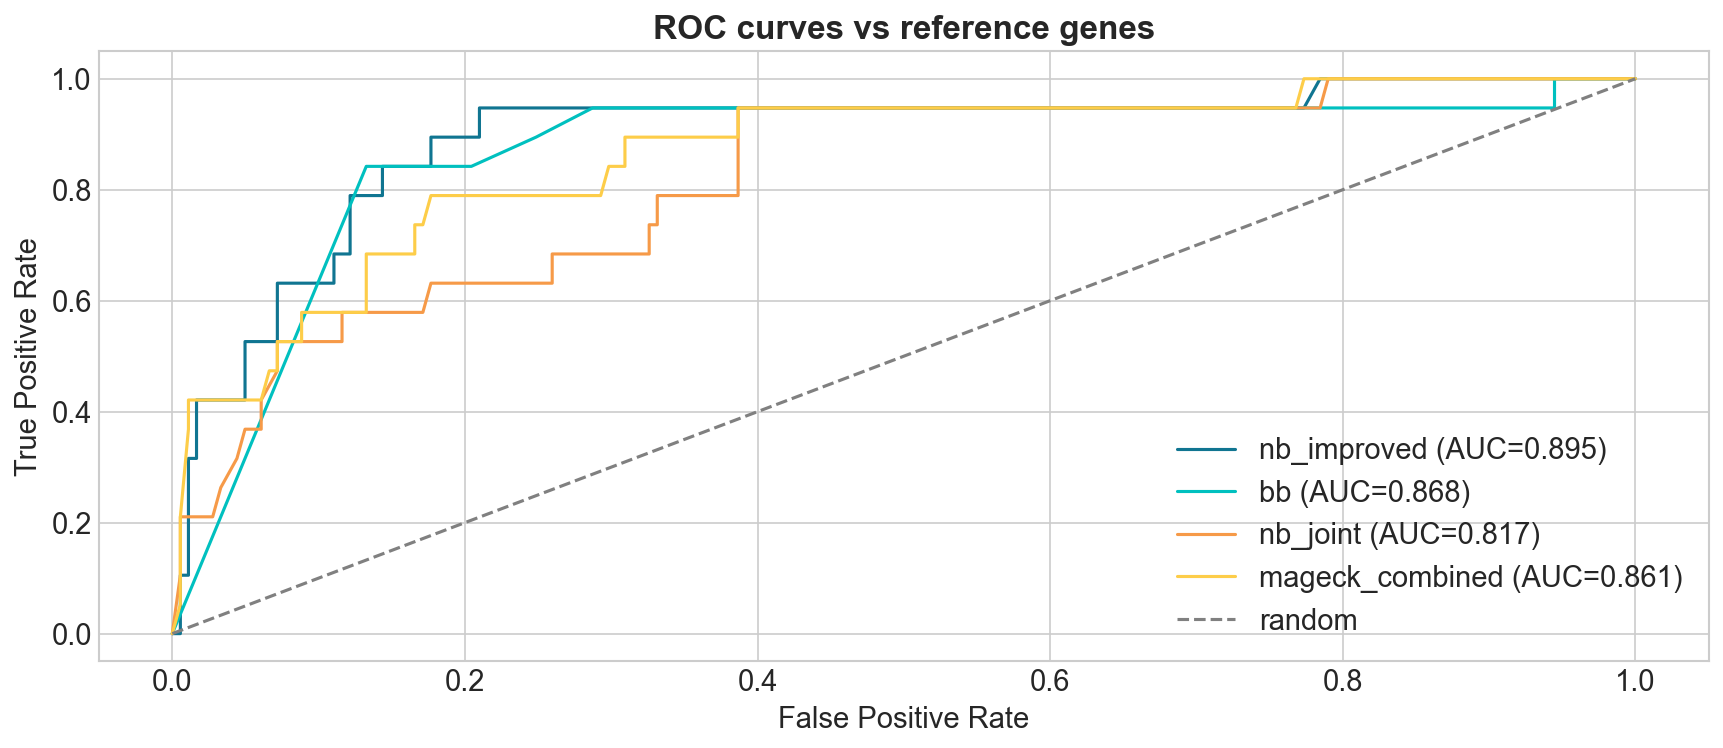

In [159]:
# Build ROC curves for all available methods using reference labels (canonicalized)
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Inputs and artifacts
table_dir = Path(project_root) / "outputs" / "tables"
fig_dir = Path(project_root) / "outputs" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

# Canonical labels: prefer saved labels; else build from data/reference_genes.txt and persist for consistency
labels_path = table_dir / "bench_reference_labels.csv"
labels = None
if labels_path.exists():
    try:
        labdf = pd.read_csv(labels_path)
        if {'gene','is_reference'}.issubset(labdf.columns):
            labels = labdf.set_index('gene')['is_reference'].astype(bool)
    except Exception as e:
        print(f"Failed to load saved labels: {e}")
if labels is None:
    try:
        # Build from text file and available gene universe
        ref_txt = Path(project_root) / 'data' / 'reference_genes.txt'
        ref_genes = set(pd.read_csv(ref_txt, header=None, names=['gene'])['gene'].astype(str).str.strip().tolist()) if ref_txt.exists() else set()
        # Universe: genes present in combined_model_summaries and/or mageck
        universe = set()
        try:
            combined = pd.read_csv(table_dir / 'combined_model_summaries.csv')
            if 'gene' in combined.columns:
                universe |= set(combined['gene'].astype(str))
        except Exception:
            pass
        try:
            mg = pd.read_csv(table_dir / 'mageck_combined_rank.csv') if (table_dir / 'mageck_combined_rank.csv').exists() else pd.read_csv(Path(project_root)/'data'/'gene_summary.csv')
            mg = mg.rename(columns={'id':'gene','Gene':'gene','gene':'gene'})
            if 'gene' in mg.columns:
                universe |= set(mg['gene'].astype(str))
        except Exception:
            pass
        genes_sorted = sorted(universe)
        labels = pd.Series(index=genes_sorted, data=False, dtype=bool)
        inter = list(ref_genes & set(genes_sorted))
        if inter:
            labels.loc[inter] = True
        # Save canonical labels for reproducibility
        pd.DataFrame({'gene': labels.index, 'is_reference': labels.values}).to_csv(labels_path, index=False)
        print(f"Saved canonical labels to: {labels_path} (n_pos={labels.sum()}, n={len(labels)})")
    except Exception as e:
        print(f"Failed to build labels: {e}")

# Load scores per method direction-agnostically from combined_model_summaries
scores = {}
combined = None
try:
    combined = pd.read_csv(table_dir / "combined_model_summaries.csv")
    # Helper to compute direction-agnostic evidence: prefer lfsr -> 1-lfsr; else PSP -> 1-min(PSP,1-PSP); else abs(effect)
    def evidence(df, prefix):
        cols = df.columns
        lfsr = f"{prefix}_lfsr"
        psp = f"{prefix}_psp"
        eff = f"{prefix}_effect"
        if lfsr in cols:
            e = 1.0 - df[lfsr].astype(float)
        elif psp in cols:
            p = df[psp].astype(float)
            e = 1.0 - np.minimum(p, 1.0 - p)
        elif eff in cols:
            e = df[eff].abs().astype(float)
        else:
            return None
        return pd.Series(e.values, index=df['gene'].astype(str))

    for method in ['nb_improved','bb','pl','nb_joint']:
        e = evidence(combined, method)
        if e is not None:
            scores[method] = e.dropna()
except Exception as e:
    print(f"Skipping Bayesian model scores: {e}")

# MAGeCK combined
try:
    if (table_dir / "mageck_combined_rank.csv").exists():
        mageck = pd.read_csv(table_dir / "mageck_combined_rank.csv")
        m = mageck.rename(columns={'id':'gene','Gene':'gene'})
        assert 'gene' in m.columns and 'mageck_combined_rank' in m.columns
        sc = 1.0 / m['mageck_combined_rank'].astype(float)
        scores['mageck_combined'] = pd.Series(sc.values, index=m['gene'].astype(str))
    else:
        mageck_raw = pd.read_csv(Path(project_root) / "data" / "gene_summary.csv")
        # same fallback as before
        def find_col(options):
            for o in options:
                if o in mageck_raw.columns:
                    return o
            return None
        pos_score = find_col(["pos|score","pos_score","pos|score:-log10(p-value)"])
        neg_score = find_col(["neg|score","neg_score","neg|score:-log10(p-value)"])
        pos_p = find_col(["pos|p-value","pos_p","pos|pvalue","pos|p.value"])
        neg_p = find_col(["neg|p-value","neg_p","neg|pvalue","neg|p.value"])
        pos_lfc = find_col(["pos|lfc","pos_lfc","pos|mean_lfc","pos|avg_lfc"])
        neg_lfc = find_col(["neg|lfc","neg_lfc","neg|mean_lfc","neg|avg_lfc"])
        dfm = mageck_raw.rename(columns={"id":"gene","Gene":"gene","gene":"gene"})
        vals = {}
        if pos_score is not None and neg_score is not None:
            vals["score"] = dfm[[pos_score, neg_score]].min(axis=1)
        if pos_p is not None and neg_p is not None:
            vals["p"] = dfm[[pos_p, neg_p]].min(axis=1)
        if pos_lfc is not None and neg_lfc is not None:
            vals["abs_lfc"] = dfm[[pos_lfc, neg_lfc]].abs().max(axis=1)
        mag = pd.DataFrame(vals)
        mag.insert(0, "gene", dfm["gene"])
        parts = []
        if 'score' in mag: parts.append(mag['score'].rank(method='average', ascending=True))
        if 'p' in mag: parts.append(mag['p'].rank(method='average', ascending=True))
        if 'abs_lfc' in mag: parts.append(mag['abs_lfc'].rank(method='average', ascending=False))
        if len(parts)>0:
            mag['combined_rank'] = np.vstack(parts).mean(axis=0) if len(parts)>1 else parts[0]
            mag['score'] = 1.0 / mag['combined_rank'].astype(float)
            scores['mageck_combined'] = pd.Series(mag['score'].values, index=mag['gene'].astype(str))
except Exception as e:
    print(f"Skipping MAGeCK combined score: {e}")

# Align all series on a common gene universe and compute ROC
roc_records = []
if labels is not None and len(scores) > 0 and len(labels.index) > 0:
    # Common set = intersection of labels and all score indices
    common = set(labels.index)
    for s in scores.values():
        common &= set(s.index)
    common = sorted(common)
    if len(common) == 0:
        print("No common genes between labels and scores.")
    else:
        y_true = labels.loc[common].astype(int).values
        pos = y_true.sum()
        print(f"ROC universe: n={len(common)}, positives={pos}")
        for method, s in scores.items():
            y_score = s.loc[common].values
            # Guard degenerate case: constant scores
            if np.allclose(np.nanstd(y_score), 0.0):
                print(f"Skipping {method}: constant score after alignment")
                continue
            fpr, tpr, thr = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr)
            roc_records.append({"method": method, "fpr": fpr, "tpr": tpr, "auc": roc_auc})

# Plot
if roc_records:
    plt.figure(dpi=150)
    sns.set_style("whitegrid")
    for rec in roc_records:
        plt.plot(rec["fpr"], rec["tpr"], label=f"{rec['method']} (AUC={rec['auc']:.3f})")
    plt.plot([0,1], [0,1], linestyle="--", color="gray", label="random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curves vs reference genes")
    plt.legend(frameon=False)
    plt.tight_layout()
    out_path = fig_dir / "bench_reference_roc_curves_incl_mageck.png"
    plt.savefig(out_path)
    print(f"Saved ROC figure to: {out_path}")
    # Save numeric ROC points
    rows = []
    for rec in roc_records:
        rows.extend([{
            "method": rec["method"],
            "fpr": float(f),
            "tpr": float(t),
            "auc": rec["auc"]
        } for f, t in zip(rec["fpr"], rec["tpr"])])
    out_csv = table_dir / "bench_reference_roc_points_incl_mageck.csv"
    pd.DataFrame(rows).to_csv(out_csv, index=False)
    print(f"Saved ROC points to: {out_csv}")
else:
    print("No ROC data to plot. Ensure combined_model_summaries.csv, MAGeCK gene_summary/rank, and reference labels are available.")

## Precision–Recall curves and AUPRC (models + MAGeCK combined)

This plots Precision–Recall (PR) curves and computes AUPRC for each method using a direction-agnostic score:
- Bayesian models use 1 − lfsr (higher = stronger evidence).
- MAGeCK uses the inverse of the combined rank (monotonic with rank).
The horizontal dashed line indicates the positive class prevalence (baseline).

PR universe: n=200, positives=19, baseline=0.095
Skipping pl: constant score after alignment
Saved PR figure to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/figures/bench_reference_pr_curves_incl_mageck.png
Saved PR points to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bench_reference_pr_points_incl_mageck.csv
Saved AP by method to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bench_reference_average_precision_incl_mageck.csv


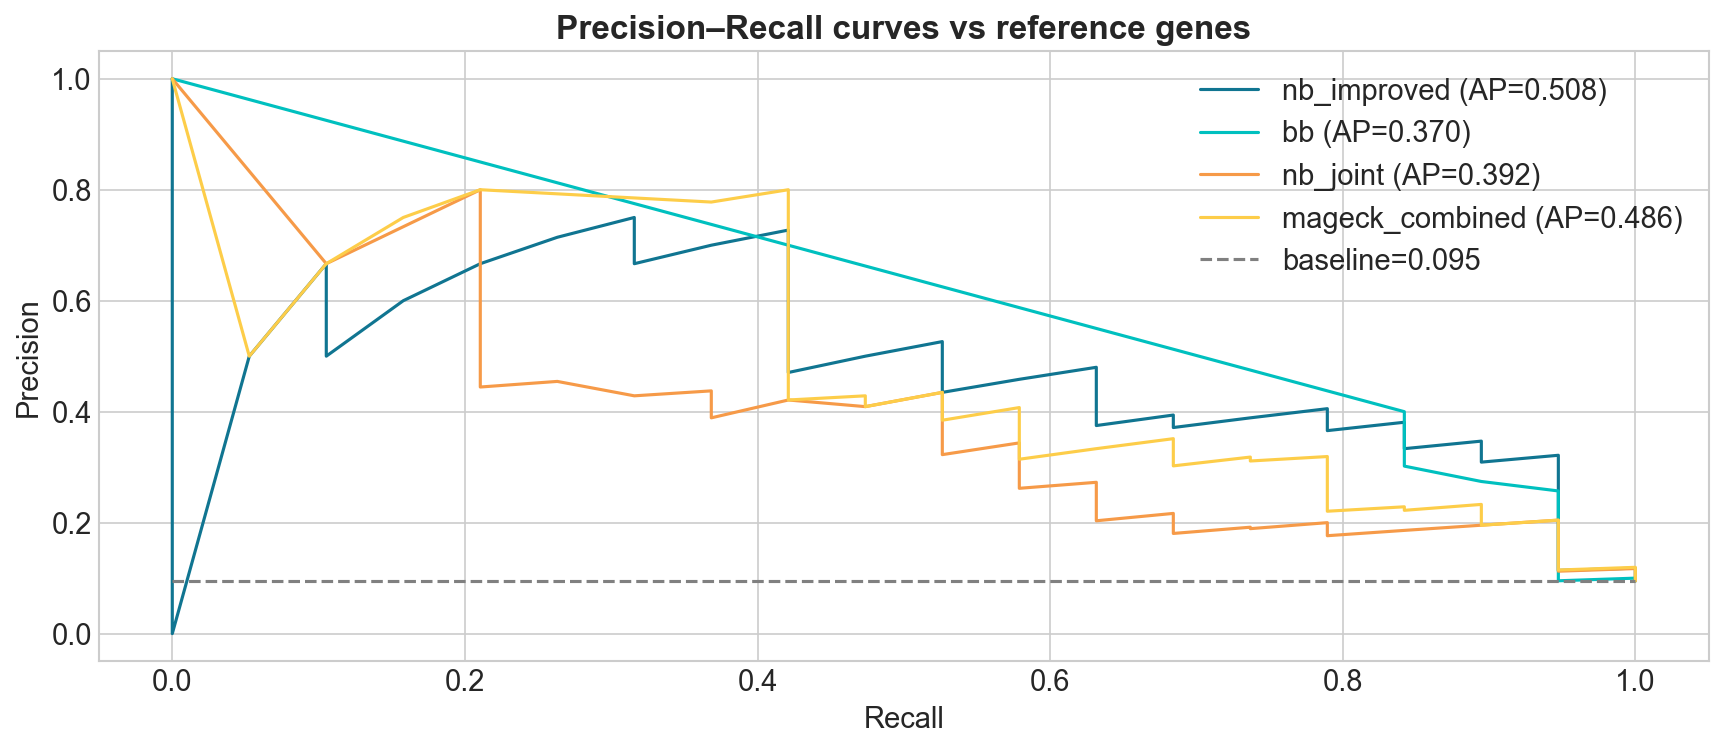

In [157]:
# Build PR curves (AUPRC) with canonical labels and harmonized evidence mapping
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Directories
table_dir = Path(project_root) / "outputs" / "tables"
fig_dir = Path(project_root) / "outputs" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

# 1) Load canonical labels; if missing, build and persist
labels_path = table_dir / "bench_reference_labels.csv"
labels = None
if labels_path.exists():
    try:
        labdf = pd.read_csv(labels_path)
        if {'gene','is_reference'}.issubset(labdf.columns):
            labels = labdf.set_index('gene')['is_reference'].astype(bool)
    except Exception as e:
        print(f"Failed to load saved labels: {e}")
if labels is None:
    try:
        ref_txt = Path(project_root) / 'data' / 'reference_genes.txt'
        ref_genes = set(pd.read_csv(ref_txt, header=None, names=['gene'])['gene'].astype(str).str.strip().tolist()) if ref_txt.exists() else set()
        universe = set()
        try:
            combined = pd.read_csv(table_dir / 'combined_model_summaries.csv')
            if 'gene' in combined.columns:
                universe |= set(combined['gene'].astype(str))
        except Exception:
            pass
        try:
            mg = pd.read_csv(table_dir / 'mageck_combined_rank.csv') if (table_dir / 'mageck_combined_rank.csv').exists() else pd.read_csv(Path(project_root)/'data'/'gene_summary.csv')
            mg = mg.rename(columns={'id':'gene','Gene':'gene','gene':'gene'})
            if 'gene' in mg.columns:
                universe |= set(mg['gene'].astype(str))
        except Exception:
            pass
        genes_sorted = sorted(universe)
        labels = pd.Series(index=genes_sorted, data=False, dtype=bool)
        inter = list(ref_genes & set(genes_sorted))
        if inter:
            labels.loc[inter] = True
        pd.DataFrame({'gene': labels.index, 'is_reference': labels.values}).to_csv(labels_path, index=False)
        print(f"Saved canonical labels to: {labels_path} (n_pos={labels.sum()}, n={len(labels)})")
    except Exception as e:
        print(f"Failed to build labels: {e}")

# 2) Load scores from combined_model_summaries with direction-agnostic mapping
scores = {}
try:
    combined = pd.read_csv(table_dir / "combined_model_summaries.csv")
    def evidence(df, prefix):
        cols = df.columns
        lfsr = f"{prefix}_lfsr"
        psp = f"{prefix}_psp"
        eff = f"{prefix}_effect"
        if lfsr in cols:
            e = 1.0 - df[lfsr].astype(float)
        elif psp in cols:
            p = df[psp].astype(float)
            e = 1.0 - np.minimum(p, 1.0 - p)
        elif eff in cols:
            e = df[eff].abs().astype(float)
        else:
            return None
        return pd.Series(e.values, index=df['gene'].astype(str))
    for method in ['nb_improved','bb','pl','nb_joint']:
        e = evidence(combined, method)
        if e is not None:
            scores[method] = e.dropna()
except Exception as e:
    print(f"Skipping Bayesian model scores: {e}")

# 3) MAGeCK combined score (1 / rank), from precomputed or fallback
try:
    if (table_dir / "mageck_combined_rank.csv").exists():
        mageck = pd.read_csv(table_dir / "mageck_combined_rank.csv")
        m = mageck.rename(columns={'id':'gene','Gene':'gene'})
        assert 'gene' in m.columns and 'mageck_combined_rank' in m.columns
        sc = 1.0 / m['mageck_combined_rank'].astype(float)
        scores['mageck_combined'] = pd.Series(sc.values, index=m['gene'].astype(str))
    else:
        mageck_raw = pd.read_csv(Path(project_root) / "data" / "gene_summary.csv")
        def find_col(options):
            for o in options:
                if o in mageck_raw.columns:
                    return o
            return None
        pos_score = find_col(["pos|score","pos_score","pos|score:-log10(p-value)"])
        neg_score = find_col(["neg|score","neg_score","neg|score:-log10(p-value)"])
        pos_p = find_col(["pos|p-value","pos_p","pos|pvalue","pos|p.value"])
        neg_p = find_col(["neg|p-value","neg_p","neg|pvalue","neg|p.value"])
        pos_lfc = find_col(["pos|lfc","pos_lfc","pos|mean_lfc","pos|avg_lfc"])
        neg_lfc = find_col(["neg|lfc","neg_lfc","neg|mean_lfc","neg|avg_lfc"])
        dfm = mageck_raw.rename(columns={"id":"gene","Gene":"gene","gene":"gene"})
        vals = {}
        if pos_score is not None and neg_score is not None:
            vals["score"] = dfm[[pos_score, neg_score]].min(axis=1)
        if pos_p is not None and neg_p is not None:
            vals["p"] = dfm[[pos_p, neg_p]].min(axis=1)
        if pos_lfc is not None and neg_lfc is not None:
            vals["abs_lfc"] = dfm[[pos_lfc, neg_lfc]].abs().max(axis=1)
        mag = pd.DataFrame(vals)
        mag.insert(0, "gene", dfm["gene"])
        parts = []
        if 'score' in mag: parts.append(mag['score'].rank(method='average', ascending=True))
        if 'p' in mag: parts.append(mag['p'].rank(method='average', ascending=True))
        if 'abs_lfc' in mag: parts.append(mag['abs_lfc'].rank(method='average', ascending=False))
        if len(parts)>0:
            mag['combined_rank'] = np.vstack(parts).mean(axis=0) if len(parts)>1 else parts[0]
            mag['score'] = 1.0 / mag['combined_rank'].astype(float)
            scores['mageck_combined'] = pd.Series(mag['score'].values, index=mag['gene'].astype(str))
except Exception as e:
    print(f"Skipping MAGeCK combined score: {e}")

# 4) Align universe and build PR curves
pr_records = []
if labels is not None and len(scores) > 0 and len(labels.index) > 0:
    common = set(labels.index)
    for s in scores.values():
        common &= set(s.index)
    common = sorted(common)
    if len(common) == 0:
        print("No common genes between labels and scores.")
    else:
        y_true = labels.loc[common].astype(int).values
        pos_rate = float(y_true.mean())
        print(f"PR universe: n={len(common)}, positives={y_true.sum()}, baseline={pos_rate:.3f}")
        for method, s in scores.items():
            y_score = s.loc[common].values
            if np.allclose(np.nanstd(y_score), 0.0):
                print(f"Skipping {method}: constant score after alignment")
                continue
            precision, recall, thr = precision_recall_curve(y_true, y_score)
            ap = average_precision_score(y_true, y_score)
            pr_records.append({"method": method, "precision": precision, "recall": recall, "ap": ap, "baseline": pos_rate})

# 5) Plot and save
if pr_records:
    plt.figure(dpi=150)
    sns.set_style("whitegrid")
    for rec in pr_records:
        plt.plot(rec["recall"], rec["precision"], label=f"{rec['method']} (AP={rec['ap']:.3f})")
    plt.hlines(pr_records[0]['baseline'], 0, 1, colors='gray', linestyles='--', label=f"baseline={pr_records[0]['baseline']:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall curves vs reference genes")
    plt.legend(frameon=False)
    plt.tight_layout()
    out_path = fig_dir / "bench_reference_pr_curves_incl_mageck.png"
    plt.savefig(out_path)
    print(f"Saved PR figure to: {out_path}")
    # Save numeric points
    rows = []
    for rec in pr_records:
        rows.extend([{
            "method": rec["method"],
            "recall": float(r),
            "precision": float(p),
            "ap": rec["ap"],
            "baseline": rec["baseline"]
        } for r, p in zip(rec["recall"], rec["precision"])])
    out_csv = table_dir / "bench_reference_pr_points_incl_mageck.csv"
    pd.DataFrame(rows).to_csv(out_csv, index=False)
    print(f"Saved PR points to: {out_csv}")
    # Save AP per method
    ap_rows = [{"method": rec["method"], "average_precision": rec["ap"], "baseline_prevalence": rec["baseline"]} for rec in pr_records]
    ap_csv = table_dir / "bench_reference_average_precision_incl_mageck.csv"
    pd.DataFrame(ap_rows).to_csv(ap_csv, index=False)
    print(f"Saved AP by method to: {ap_csv}")
else:
    print("No PR data to plot. Ensure combined_model_summaries.csv, MAGeCK rank/raw, and reference labels are available.")

## Model comparison (minimal set): PPC / WAIC · PSIS-LOO / Practical performance

Per the plan, implement the following:
- Fit diagnostics: posterior predictive checks (PPC) → within-replicate variance, zero rate, tail heaviness
- Information criteria: WAIC and PSIS-LOO (with standard errors where available)
- Practical performance: Top‑N stability and concordance, agreement with reference genes (biological plausibility)

In [160]:
# Model comparison summary: PPC, WAIC/LOO, and practical performance
import pandas as pd, numpy as np
import arviz as az
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

table_dir = Path(project_root) / "outputs" / "tables"
fig_dir = Path(project_root) / "outputs" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

models = [
    ("nb_improved", "outputs/tables/bayes_gene_summary_nb_improved_vi.csv"),
    ("bb", "outputs/tables/bayes_gene_summary_bb_vi.csv"),
    ("pl", "outputs/tables/bayes_gene_summary_pl_vi.csv"),
    ("nb_joint", "outputs/tables/bayes_gene_summary_nb_joint_vi.csv"),
]

available = []
for name, rel in models:
    p = Path(project_root) / rel
    if p.exists():
        available.append(name)

print("Available models:", available)

# 1) PPC: summarize observed; compute per-model only if a distinct idata with posterior_predictive exists.
ppc_rows = []
def _ppc_stats(df_counts):
    stats = {}
    if {'gene','sample_id','count'}.issubset(df_counts.columns):
        v = df_counts.groupby(['gene','sample_id'])['count'].var().groupby('gene').mean()
        stats['replicate_var_mean'] = float(np.nanmean(v.values)) if len(v) else np.nan
    else:
        stats['replicate_var_mean'] = np.nan
    if 'count' in df_counts.columns:
        stats['zero_rate'] = float((df_counts['count'] == 0).mean())
        stats['q95'] = float(np.quantile(df_counts['count'].values, 0.95))
    else:
        stats['zero_rate'] = np.nan
        stats['q95'] = np.nan
    return stats

try:
    obs = counts_long[['gene','sgrna','sample_id','count']].copy()
    obs_stats = _ppc_stats(obs)
    obs_stats['model'] = 'observed'
    ppc_rows.append(obs_stats)
except Exception as e:
    print(f"Could not compute observed PPC stats: {e}")

# Only use distinct idata variables if present; do NOT reuse a single idata for all models.
ppc_idatas = {
    'nb_improved': 'idata_nb_improved',
    'nb_joint': 'idata_nb_joint',
    'pl': 'idata_pl',
    'bb': 'idata_bb',
}

def _idata_ppc_stats(idata, label):
    try:
        if not hasattr(idata, 'posterior_predictive') or idata.posterior_predictive is None:
            return None
        ysim = idata.posterior_predictive
        var = None
        for cand in ['y','y_obs','counts','y_rep']:
            if cand in ysim.data_vars:
                var = cand
                break
        if var is None:
            return None
        # Stack chain/draw into one dimension, keep all simulated observation values
        arr = ysim[var].stack(sample=("chain","draw")).values  # shape: (sample, obs_dims...)
        flat = arr.reshape(arr.shape[0], -1)  # (samples, n_obs_flat)
        # Compute distribution-wide zero rate and tail thickness over all simulated counts
        zeros = (flat == 0).mean()  # fraction over all elements
        q95 = np.quantile(flat, 0.95)
        stats = {
            'replicate_var_mean': np.nan,  # need aligned sample_id for replicate variance
            'zero_rate': float(zeros),
            'q95': float(q95),
            'model': label
        }
        return stats
    except Exception as e:
        print(f"PPC failed for {label}: {e}")
        return None

for lab in available:
    varname = ppc_idatas.get(lab)
    if varname and varname in globals():
        res = _idata_ppc_stats(globals()[varname], lab)
        if res:
            ppc_rows.append(res)
    else:
        print(f"Skip PPC for {lab}: no distinct idata with posterior_predictive available.")

ppc_df = pd.DataFrame(ppc_rows) if ppc_rows else pd.DataFrame()
if not ppc_df.empty:
    out_csv = table_dir / "model_ppc_summary.csv"
    ppc_df.to_csv(out_csv, index=False)
    print(f"Saved PPC summary to: {out_csv}")
else:
    print("PPC summary not available (no idata posterior_predictive in memory).")

# 2) WAIC / PSIS-LOO via ArviZ (requires log_likelihood recorded in InferenceData)
ic_rows = []
def _compute_ic(idata, label):
    try:
        loo = az.loo(idata, pointwise=False)
        waic = az.waic(idata, pointwise=False)
        return {
            "model": label,
            "elpd_loo": float(loo.elpd_loo),
            "elpd_loo_se": float(loo.se),
            "elpd_waic": float(waic.elpd_waic),
            "elpd_waic_se": float(waic.se)
        }
    except Exception as e:
        print(f"IC failed for {label}: {e}")
        return None

ic_sources = {
    'nb_improved': 'idata_nb_improved',
    'nb_joint': 'idata_nb_joint',
    'pl': 'idata_pl',
    'bb': 'idata_bb',
}
for lab in available:
    varname = ic_sources.get(lab)
    if varname and varname in globals():
        res = _compute_ic(globals()[varname], lab)
        if res:
            ic_rows.append(res)
    else:
        print(f"Skip IC for {lab}: no distinct idata with log_likelihood available.")

ic_df = pd.DataFrame(ic_rows) if ic_rows else pd.DataFrame()
if not ic_df.empty:
    out_csv = table_dir / "model_ic_waic_loo.csv"
    ic_df.to_csv(out_csv, index=False)
    print(f"Saved IC summary to: {out_csv}")
else:
    print("IC summary not available (no log_likelihood in idata or idata not in memory).")

# 3) Practical performance: stability, correlation vs nb_joint, AUPRC
perf = pd.DataFrame()
try:
    # Top-N overlap Jaccard: mean Jaccard vs nb_joint for each method across N
    topN = pd.read_csv(table_dir / "bench_topN_overlap_incl_mageck.csv")
    def mean_jaccard_vs_nb(df, method):
        sub = df[((df['model_a'] == method) & (df['model_b'] == 'nb_joint')) | ((df['model_b'] == method) & (df['model_a'] == 'nb_joint'))]
        return sub['jaccard'].mean() if not sub.empty else np.nan
    methods = sorted(set(topN['model_a']).union(set(topN['model_b'])))
    jacc = {m: mean_jaccard_vs_nb(topN, m) for m in methods}
    perf = pd.DataFrame({'method': list(jacc.keys()), 'mean_jaccard_vs_nb_joint': list(jacc.values())})
except Exception as e:
    print(f"Top-N Jaccard parse failed: {e}")

try:
    # Rank correlations: square matrix with index column 'Unnamed: 0'
    corr = pd.read_csv(table_dir / "bench_rank_corr_spearman_incl_mageck.csv")
    if 'Unnamed: 0' in corr.columns and 'nb_joint' in corr.columns:
        corr2 = corr.rename(columns={'Unnamed: 0':'method'})[['method','nb_joint']]
        corr2 = corr2.rename(columns={'nb_joint':'spearman_vs_nb_joint'})
        perf = perf.merge(corr2, on='method', how='outer') if not perf.empty else corr2
except Exception as e:
    print(f"Correlation parse failed: {e}")

try:
    # Bootstrap stability: mean selection frequency per method; file uses 'model' and 'sel_freq'
    boot = pd.read_csv(table_dir / "bench_bootstrap_topN_selection_freq_incl_mageck.csv")
    if {'model','sel_freq'}.issubset(boot.columns):
        stab = boot.groupby('model')['sel_freq'].mean().rename('stability').reset_index().rename(columns={'model':'method'})
        perf = perf.merge(stab, on='method', how='outer') if not perf.empty else stab
except Exception as e:
    print(f"Bootstrap parse failed: {e}")

try:
    # AUPRC from average precision table
    ap = pd.read_csv(table_dir / "bench_reference_average_precision_incl_mageck.csv")
    if {'method','average_precision'}.issubset(ap.columns):
        ap2 = ap[['method','average_precision']].rename(columns={'average_precision':'auprc'})
        perf = perf.merge(ap2, on='method', how='outer') if not perf.empty else ap2
except Exception as e:
    print(f"AP parse failed: {e}")

if not perf.empty:
    out_csv = table_dir / "model_practical_performance_summary.csv"
    perf.to_csv(out_csv, index=False)
    print(f"Saved practical performance summary to: {out_csv}")
else:
    print("Practical performance summary not available.")

# Compact on-screen view
dfs = {
    'ppc': ppc_df,
    'ic': ic_df,
    'perf': perf
}
for k, d in dfs.items():
    print("\n==", k.upper(), "==")
    with pd.option_context('display.max_columns', None, 'display.width', 120):
        print(d.head())

Available models: ['nb_improved', 'bb', 'pl', 'nb_joint']
Skip PPC for nb_improved: no distinct idata with posterior_predictive available.
Skip PPC for bb: no distinct idata with posterior_predictive available.
Skip PPC for pl: no distinct idata with posterior_predictive available.
Skip PPC for nb_joint: no distinct idata with posterior_predictive available.
Saved PPC summary to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/model_ppc_summary.csv
Skip IC for nb_improved: no distinct idata with log_likelihood available.
Skip IC for bb: no distinct idata with log_likelihood available.
Skip IC for pl: no distinct idata with log_likelihood available.
Skip IC for nb_joint: no distinct idata with log_likelihood available.
IC summary not available (no log_likelihood in idata or idata not in memory).
Saved practical performance summary to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/model_practical_performance_summary.csv

== PPC ==
   replicate_var_mean  

In [147]:
# Helper: attach log_likelihood and posterior_predictive to current model's InferenceData (if available)
import pymc as pm
import arviz as az
from pathlib import Path

def attach_ic_and_ppc(idata, model):
    updated = idata
    try:
        # Try to compute and attach log_likelihood
        with model:
            try:
                updated = pm.compute_log_likelihood(updated)  # adds log_likelihood group
                print("Attached log_likelihood")
            except Exception as e:
                print(f"compute_log_likelihood failed: {e}")
            # Identify observed RV names
            obs_rvs = [rv.name for rv in getattr(model, 'observed_RVs', [])]
            if len(obs_rvs) == 0:
                # Fallback: search common names
                obs_rvs = [n for n in ['y','y_obs','counts'] if n in model.named_vars]
            if len(obs_rvs) > 0:
                try:
                    updated = pm.sample_posterior_predictive(updated, var_names=obs_rvs, extend_inferencedata=True, progressbar=False)
                    print(f"Attached posterior_predictive for: {obs_rvs}")
                except Exception as e:
                    print(f"sample_posterior_predictive failed: {e}")
            else:
                print("No observed RVs found to sample posterior predictive.")
    except Exception as e:
        print(f"attach_ic_and_ppc failed: {e}")
    return updated

# Attempt for the currently loaded nb_model/idata_vi (if present)
try:
    if 'nb_model' in globals() and 'idata_vi' in globals():
        idata_vi = attach_ic_and_ppc(idata_vi, nb_model)
    else:
        print("nb_model or idata_vi not available in this session.")
except Exception as e:
    print("Attachment failed:", e)

compute_log_likelihood failed: 'alpha'


Sampling: [alpha, beta, y]


Attached posterior_predictive for: ['y']


In [161]:
# Compare ROC/AUPRC under different evaluation universes to reconcile discrepancies
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score

table_dir = Path(project_root) / "outputs" / "tables"

def load_labels():
    lab = pd.read_csv(table_dir / 'bench_reference_labels.csv')
    return lab.set_index('gene')['is_reference'].astype(bool)

def load_scores():
    cm = pd.read_csv(table_dir / 'combined_model_summaries.csv')
    def ev(df, prefix):
        cols = df.columns
        if f"{prefix}_lfsr" in cols:
            return 1.0 - df[f"{prefix}_lfsr"].astype(float)
        if f"{prefix}_psp" in cols:
            p = df[f"{prefix}_psp"].astype(float)
            return 1.0 - np.minimum(p, 1.0 - p)
        if f"{prefix}_effect" in cols:
            return df[f"{prefix}_effect"].abs().astype(float)
        return None
    scores = {}
    for m in ['nb_improved','bb','pl','nb_joint']:
        s = ev(cm, m)
        if s is not None:
            scores[m] = pd.Series(s.values, index=cm['gene'].astype(str))
    # MAGeCK combined if available
    mgp = table_dir / 'mageck_combined_rank.csv'
    if mgp.exists():
        mg = pd.read_csv(mgp)
        mg = mg.rename(columns={'id':'gene','Gene':'gene'})
        if {'gene','mageck_combined_rank'}.issubset(mg.columns):
            scores['mageck_combined'] = pd.Series(1.0/mg['mageck_combined_rank'].astype(float).values, index=mg['gene'].astype(str))
    return scores

def eval_universe(universe_name, labels, scores, gene_set):
    # Intersect labels and all method score indices within given gene_set
    common = set(gene_set) & set(labels.index)
    for s in scores.values():
        common &= set(s.index)
    common = sorted(common)
    if not common:
        return None, None
    y = labels.loc[common].astype(int).values
    rows = []
    for name, s in scores.items():
        sc = s.loc[common].values
        if np.allclose(np.nanstd(sc), 0.0):
            continue
        rows.append({'universe': universe_name, 'model': name, 'ROC_AUC': roc_auc_score(y, sc), 'AUPRC': average_precision_score(y, sc), 'n': len(common), 'positives': int(y.sum())})
    return pd.DataFrame(rows), {'n': len(common), 'positives': int(y.sum())}

labels = load_labels()
scores = load_scores()

# Universe options
genes_all = set(labels.index)
for s in scores.values():
    genes_all &= set(s.index)
# Combined-only universe (legacy-like): genes present in combined_model_summaries
cm = pd.read_csv(table_dir / 'combined_model_summaries.csv')
genes_combined_only = set(cm['gene'].astype(str))

dfs = []
meta = {}
for name, geneset in [("all_common", genes_all), ("combined_only", genes_combined_only)]:
    df, m = eval_universe(name, labels, scores, geneset)
    if df is not None:
        dfs.append(df)
        meta[name] = m

if dfs:
    out = pd.concat(dfs, ignore_index=True)
    out_path = table_dir / 'bench_reference_roc_auprc_comparison.csv'
    out.to_csv(out_path, index=False)
    print(f"Saved comparison AUC/AUPRC to: {out_path}")
    print(out)
    print("Universe sizes:", meta)
else:
    print("No evaluation universes yielded overlap.")

Saved comparison AUC/AUPRC to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bench_reference_roc_auprc_comparison.csv
        universe        model   ROC_AUC     AUPRC    n  positives
0     all_common  nb_improved  0.895028  0.507637  200         19
1     all_common           bb  0.868421  0.370070  200         19
2     all_common     nb_joint  0.816516  0.391952  200         19
3  combined_only  nb_improved  0.895028  0.507637  200         19
4  combined_only           bb  0.868421  0.370070  200         19
5  combined_only     nb_joint  0.816516  0.391952  200         19
Universe sizes: {'all_common': {'n': 200, 'positives': 19}, 'combined_only': {'n': 200, 'positives': 19}}


In [162]:
# Compare PR (AUPRC) under different evaluation universes (and report prevalence)
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.metrics import precision_recall_curve, average_precision_score

table_dir = Path(project_root) / "outputs" / "tables"

def _load_labels():
    lab = pd.read_csv(table_dir / 'bench_reference_labels.csv')
    return lab.set_index('gene')['is_reference'].astype(bool)

def _load_scores():
    cm = pd.read_csv(table_dir / 'combined_model_summaries.csv')
    def ev(df, prefix):
        cols = df.columns
        if f"{prefix}_lfsr" in cols:
            return 1.0 - df[f"{prefix}_lfsr"].astype(float)
        if f"{prefix}_psp" in cols:
            p = df[f"{prefix}_psp"].astype(float)
            return 1.0 - np.minimum(p, 1.0 - p)
        if f"{prefix}_effect" in cols:
            return df[f"{prefix}_effect"].abs().astype(float)
        return None
    scores = {}
    for m in ['nb_improved','bb','pl','nb_joint']:
        s = ev(cm, m)
        if s is not None:
            scores[m] = pd.Series(s.values, index=cm['gene'].astype(str))
    # MAGeCK combined if available
    mgp = table_dir / 'mageck_combined_rank.csv'
    if mgp.exists():
        mg = pd.read_csv(mgp)
        mg = mg.rename(columns={'id':'gene','Gene':'gene'})
        if {'gene','mageck_combined_rank'}.issubset(mg.columns):
            scores['mageck_combined'] = pd.Series(1.0/mg['mageck_combined_rank'].astype(float).values, index=mg['gene'].astype(str))
    return scores

def _eval_pr(universe_name, labels, scores, gene_set):
    common = set(gene_set) & set(labels.index)
    for s in scores.values():
        common &= set(s.index)
    common = sorted(common)
    if not common:
        return None, None, None
    y = labels.loc[common].astype(int).values
    pos_rate = float(y.mean())
    rows = []
    for name, s in scores.items():
        sc = s.loc[common].values
        if np.allclose(np.nanstd(sc), 0.0):
            continue
        precision, recall, thr = precision_recall_curve(y, sc)
        ap = average_precision_score(y, sc)
        rows.append({'universe': universe_name, 'model': name, 'AUPRC': ap, 'baseline': pos_rate, 'n': len(common), 'positives': int(y.sum())})
    return pd.DataFrame(rows), common, y

labels = _load_labels()
scores = _load_scores()
genes_all = set(labels.index)
for s in scores.values():
    genes_all &= set(s.index)
cm = pd.read_csv(table_dir / 'combined_model_summaries.csv')
genes_combined_only = set(cm['gene'].astype(str))

dfs = []
for name, geneset in [("all_common", genes_all), ("combined_only", genes_combined_only)]:
    df, common, y = _eval_pr(name, labels, scores, geneset)
    if df is not None:
        dfs.append(df)
if dfs:
    out = pd.concat(dfs, ignore_index=True)
    out_path = table_dir / 'bench_reference_pr_auprc_comparison.csv'
    out.to_csv(out_path, index=False)
    print(f"Saved PR comparison AUPRC to: {out_path}")
    print(out.sort_values(['universe','model']))
else:
    print("No PR universes yielded overlap.")

Saved PR comparison AUPRC to: /Users/ryodaikim/Desktop/0.projects/CRISPR-bayes/outputs/tables/bench_reference_pr_auprc_comparison.csv
        universe        model     AUPRC  baseline    n  positives
1     all_common           bb  0.370070     0.095  200         19
0     all_common  nb_improved  0.507637     0.095  200         19
2     all_common     nb_joint  0.391952     0.095  200         19
4  combined_only           bb  0.370070     0.095  200         19
3  combined_only  nb_improved  0.507637     0.095  200         19
5  combined_only     nb_joint  0.391952     0.095  200         19
